# **N09. UNSUPERVISED LEARNING**

In [1]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import libraries.object_classification as oc
import os

from skimage.filters import threshold_otsu
from skimage.measure import regionprops, label
from scipy import stats
import operator
from sklearn.decomposition import PCA


#!pip install numpy==2.0.0

**Re-working**

In [3]:
# Load metadata of used fits.
FITS_FOLDER = "resources/database/fits_db"
fits = os.listdir(FITS_FOLDER)
fits = [pd.read_pickle(os.path.join(FITS_FOLDER, file_fits)) for file_fits in fits]

# Merge all into one file.
all_fits = pd.concat(fits, axis = 0)
print(f"Number of fits analyzed: {len(all_fits)}")

Number of fits analyzed: 30657


**Check number of analyzied files**

In [2]:
# Load metadata of used fits.
FITS_FOLDER = "resources/database/fits_db"
fits = os.listdir(FITS_FOLDER)
fits = [pd.read_pickle(os.path.join(FITS_FOLDER, file_fits)) for file_fits in fits]

# Merge all into one file.
all_fits = pd.concat(fits, axis = 0)
print(f"Number of fits analyzed: {len(all_fits)}")

# Load objects.
#objects = pd.read_pickle("objects_all.pkl").reset_index(drop = True)
#objects["REGION"] = objects["REGION"].apply(lambda x: x.flatten())
#objects["img_norm"] = objects["img_norm"].apply(lambda x: x.flatten())
#objects.to_parquet("objects_all.parquet")

objects = pd.read_parquet("objects_all.parquet")
objects["REGION"] = objects["REGION"].apply(lambda x: x.reshape(61,61))
objects["img_norm"] = objects["img_norm"].apply(lambda x: x.reshape(11,11))

Number of fits analyzed: 30657


In [6]:
## Save objects into pandas.
objects.to_pickle("objects_full.pkl")

## 0. Clustering functions

**DBSCAN**

In [7]:
def dbscan(samples, eps, min_samples):
    """
        Density-based Spatial Clustering of Aplications with Noise (DBSCAN) groups together points that are densely packed together.

        Parameters:
            samples (list): flattened images to be analyzed.
            eps (float): maximum distance between two samples to be consider neighbors.
            min_samples (int): maximum number of neighbors to form a dense region.
        
        Output:
            labels (list): cluster indexes: -1 -> noise; !-1 -> cluster index.
    """
    dbscan = DBSCAN(eps = eps, min_samples= min_samples)
    labels = dbscan.fit_predict(samples)

    return labels


def dbscan_samples(images, labels, n_samples):
    """
    Display obtained cluster and samples from DBSCAN algorithm.

    Parameters:
        images (list): list with flattened images.
        labels (list): obtained list with labels from dbscan algorithm.
        n_samples (int): number of samples to be displayed for each cluster.

    """

    # Retrieve shape.
    original_shape = int(images[0].shape[0])
    # Count labels and occurrences.
    unique, counts = np.unique(labels, return_counts=True)
    # Create pairs.
    pairs = list(zip(images, labels))
    fig, axis = plt.subplots(len(unique), n_samples, figsize = (n_samples, len(unique)))
    fig.suptitle("Categorization obtained from DBSCAN")

    for i in range(len(unique)):
        samples = [img.reshape(original_shape,original_shape) for img, lbl in pairs if lbl == i-1]

        for j in range(n_samples):
            axis[i,0].set_ylabel(f"Cluster {i-1} \n size: {len(samples)}")
            try:
                axis[i,j].imshow(samples[j])
                axis[i,j].set_xticks([])
                axis[i,j].set_yticks([])
            except:
                axis[i,j].axis("off")
    plt.tight_layout()
    
def dbscan_eps_finder(images, k_neighbord):
    """
    Find best eps for DBSCAN algorithm.

    Parameters:
        images (numpy): flatten images to be analyzed.
        k_neighbor (int): kth closest neighbor.

    Output:
        distances (array): ordered array with distances of each point to its kth neighbor.
        eps (float): optimal eps for the given configuration.
    """

    # Set kth neighbor.
    neigh = NearestNeighbors(n_neighbors=k_neighbord)
    nbrs = neigh.fit(images)
    distances, _ = nbrs.kneighbors(images)

    # Compute distances from every point to its kth neighbor.
    distances = np.sort(distances[:, k_neighbord-1])

    # Extraxt knee.
    knee = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
    eps = knee.knee

    return distances, eps

**K-means**

In [8]:
def k_means_nn(vectors, clusters, attempts, criteria):
    """
    Group data into K clusters based on feature similarity.

    Parameters:
        vectors (array): array with vectors to be analyzed. 
        clusters (int): number of assigned clusters.
        criteria (tuple): max number of iterations and accuracy.
        attempts (int): number of times k-means will be executed.

    Return:
        compactness (float): sum of squared distances from each point into cluster center.
        labels (list): list with obtained clusters labels.
        centers (list): coordinates of cluster centers.

    """

    compactness, labels, centers = cv2.kmeans(data=vectors.astype(np.float32),
                                          K=clusters,
                                          bestLabels=None,
                                          criteria=criteria,
                                          attempts=attempts,
                                          flags=cv2.KMEANS_PP_CENTERS)

    return compactness, labels, centers

def kmeans_sample(images, labels, n_samples):  
    """
    Display samples for each obtained cluster from K-means algorithm.

    Parameters:
        images (list): flatten input images.
        labels (array): array with obtained cluster labels.
        n_samples (int): number of samples to plot from each cluster.    
        original_shape (int): original height of the input image.
    """
    size = int(images[0].shape[0])
    # Extract clusters.
    unique, counts = np.unique(labels, return_counts=True)

    # Merge images with respective labels.
    pairs = list(zip(images, labels))

    # Create plot.
    fig, axis = plt.subplots(len(unique), n_samples, figsize = (10, 10))

    for i in range(len(unique)):
        samples = [img.reshape(size,size) for img, lbl in pairs if lbl == i]
        samples_r = random.sample(samples, n_samples)
        axis[i,0].set_ylabel(f"Cluster {i}, \n Size: {len(samples)}")
        for j in range(n_samples):
            axis[i, j].imshow(samples_r[j])
            axis[i, j].set_xticks([])
            axis[i, j].set_yticks([])

**Agglomerative clustering**

In [9]:
def agglomerative_clustering_sample(images, labels, n_samples):  
    """
    Display samples for each obtained cluster from agglomerative clustering alogorithm.

    Parameters:
        images (list): flatten input images.
        labels (array): array with obtained cluster labels.
        n_samples (int): number of samples to plot from each cluster.    
        original_shape (int): original height of the input image.
    """
    size = int(images[0].shape[0])
    # Extract clusters.
    unique, counts = np.unique(labels, return_counts=True)

    # Merge images with respective labels.
    pairs = list(zip(images, labels))

    # Create plot.
    fig, axis = plt.subplots(len(unique), n_samples, figsize = (10, 10))

    for i in range(len(unique)):
        samples = [img.reshape(size,size) for img, lbl in pairs if lbl == i]
        if len(samples) > n_samples:
            samples_r = random.sample(samples, n_samples)
        else:
            samples_r = samples
        axis[i,0].set_ylabel(f"Cluster {i}, \n Size: {len(samples)}")
        for j in range(n_samples):
            if j < len(samples_r):
                axis[i, j].imshow(samples_r[j])
                axis[i, j].set_xticks([])
                axis[i, j].set_yticks([])
            else:
                axis[i,j].axis("off")


def linkage_matrix(images, method):
    Z = linkage(images, method=method)  
    
    fig, axis = plt.subplots(1, 1, figsize = (15, 6))
    dendrogram(Z)
    axis.set_title("Dendrogram")
    axis.set_xlabel("Sample index")
    axis.set_ylabel("Distance")
    plt.show()


## 1. Clustering raw tests.

Load images and convert into list and flatten them.

In [25]:
# Load objects.
objects = pd.read_pickle("objects_all.pkl").reset_index(drop = True)

# Extract images. (small)
images = objects["img_norm"].to_list()
images_flattened = np.array([img.flatten() for img in images])

# Extract images. (medium)
cut = 15
images = objects["REGION"].apply(lambda x: x[cut:-cut, cut:-cut]).to_list()
images_flattened = np.array([img.flatten() for img in images])
images_flattened = StandardScaler().fit_transform(images_flattened)



### 1.1. K-means

Compactness: 293463.69261813164


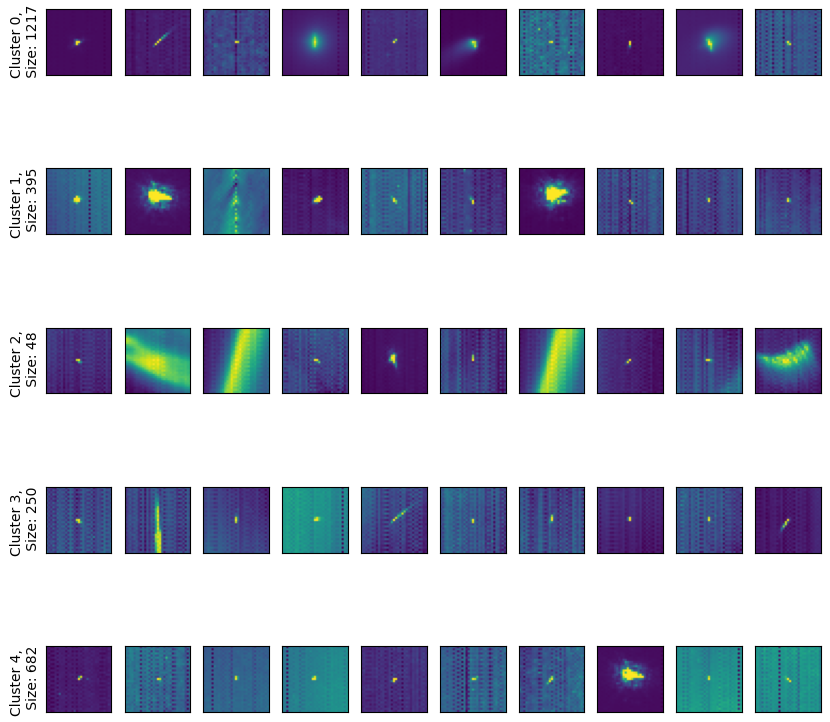

In [26]:
# K-means parameters.
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.01)
CLUSTERS = 5
ATTEMPTS = 12

# Run model.
compactness, labels, centroids = k_means_nn(images_flattened, CLUSTERS, ATTEMPTS, CRITERIA)

# Display samples.
kmeans_sample(images, labels, 10)
print(f"Compactness: {compactness}")

In [27]:
objects["knn_5cl_15cr"] = labels

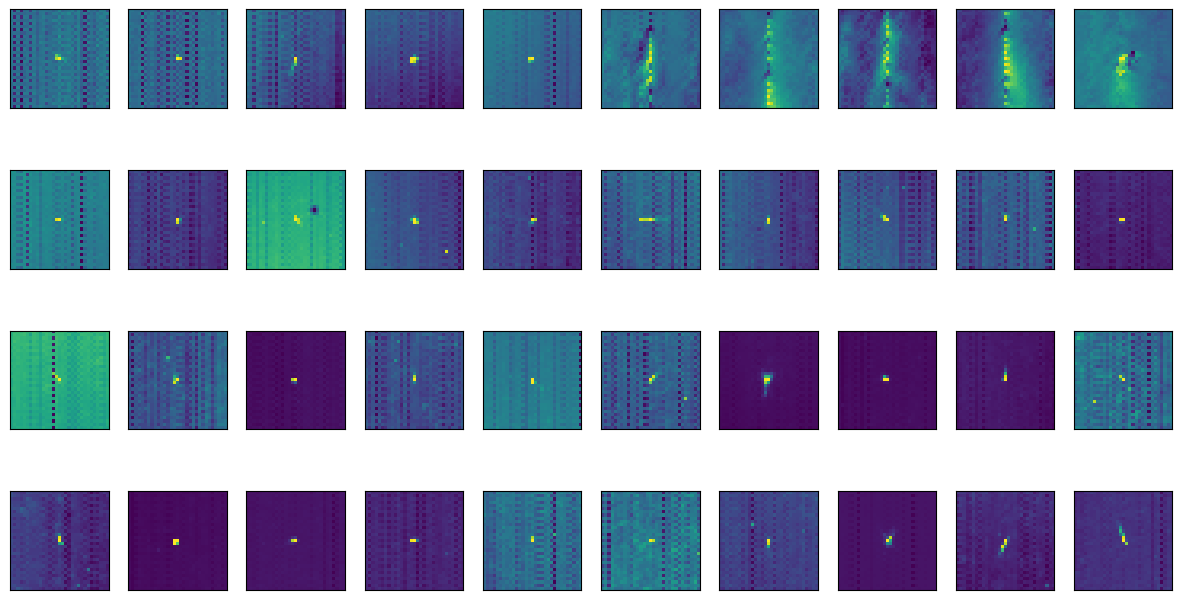

In [28]:
fig, axis = plt.subplots(4, 10, figsize = (15, 8))
axis = axis.flatten()
cut = 15
samples = objects[objects["knn_5cl_15cr"] == 0]

for i in range(40):
    img = samples["REGION"].iloc[i][cut:-cut, cut:-cut]
    axis[i].set_xticks([]), axis[i].set_yticks([])
    axis[i].imshow(img)

### 1.2. DBSCAN

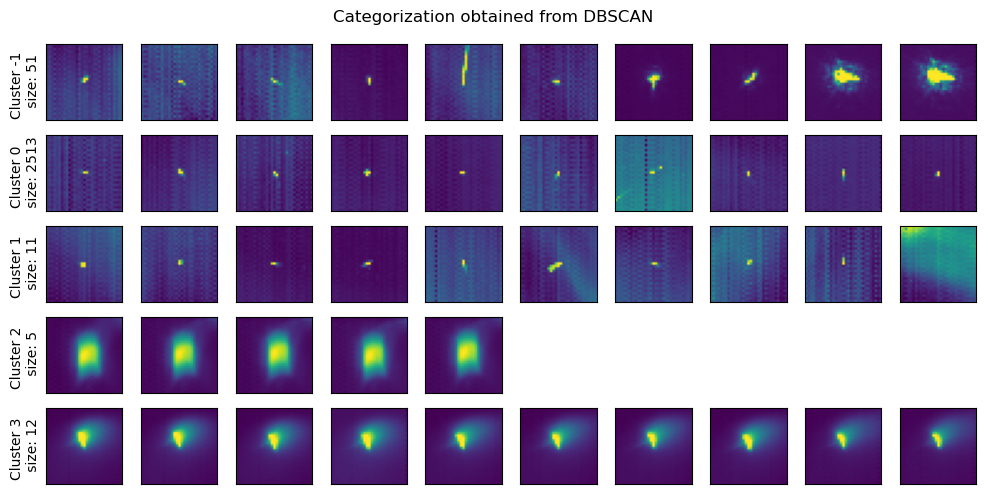

In [29]:
# Find optimal eps.
MIN_SAMPLES = 5
distances, eps = dbscan_eps_finder(images_flattened, MIN_SAMPLES )

# Run dbscan.
labels = dbscan(images_flattened, distances[eps], MIN_SAMPLES)

# Display samples.
dbscan_samples(images, labels, 10)


In [85]:
objects["dbscan_3cl_15cr"] = labels

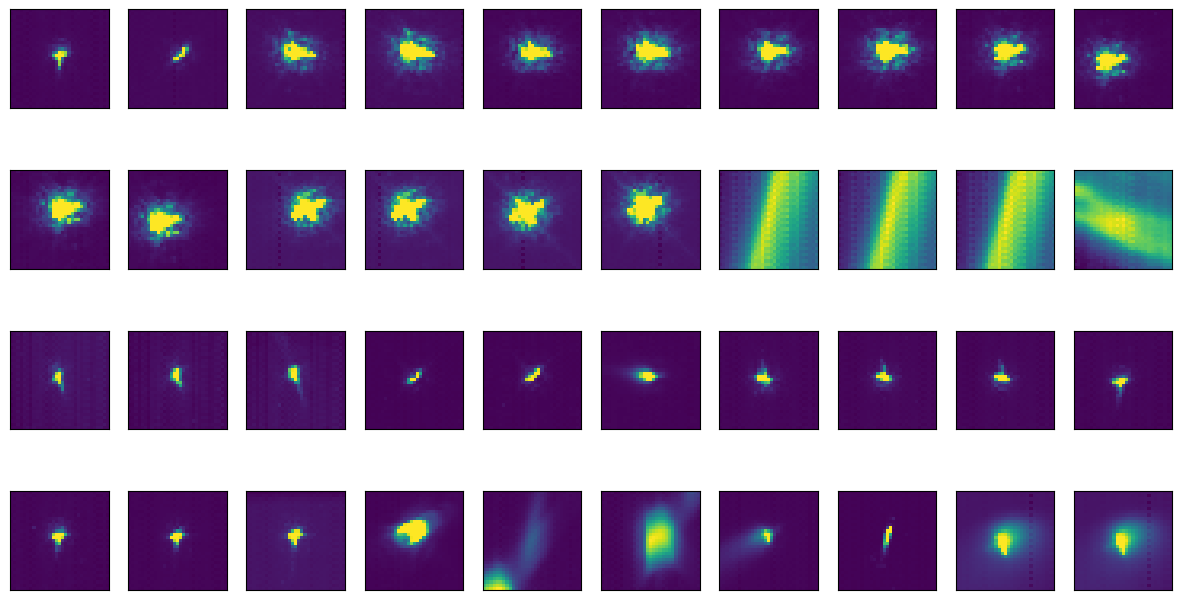

In [86]:
fig, axis = plt.subplots(4, 10, figsize = (15, 8))
axis = axis.flatten()
cut = 15
samples = objects[objects["dbscan_3cl_15cr"] == -1]

for i in range(40):
    img = samples["REGION"].iloc[i][cut:-cut, cut:-cut]
    axis[i].set_xticks([]), axis[i].set_yticks([])
    axis[i].imshow(img)

### 1.3 Agglomerative clustering

**Small size region**

images_flattened

In [22]:
len(images_flattened)

2592

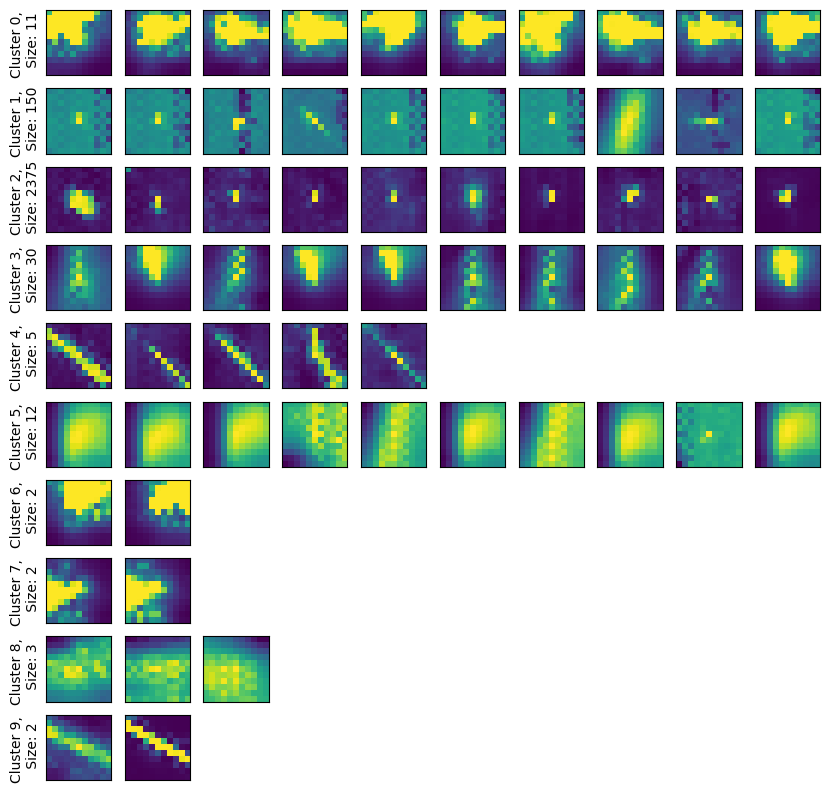

In [24]:
# Extract images. (small)
images = objects["img_norm"].to_list()
images_flattened = np.array([img.flatten() for img in images])
images_flattened = StandardScaler().fit_transform(images_flattened)

# Parameters.
LINKAGE = "complete"
N_CLUSTERS = 10

# Run model.
model = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage=LINKAGE)
labels = model.fit_predict(images_flattened)

agglomerative_clustering_sample(images, labels, 10)


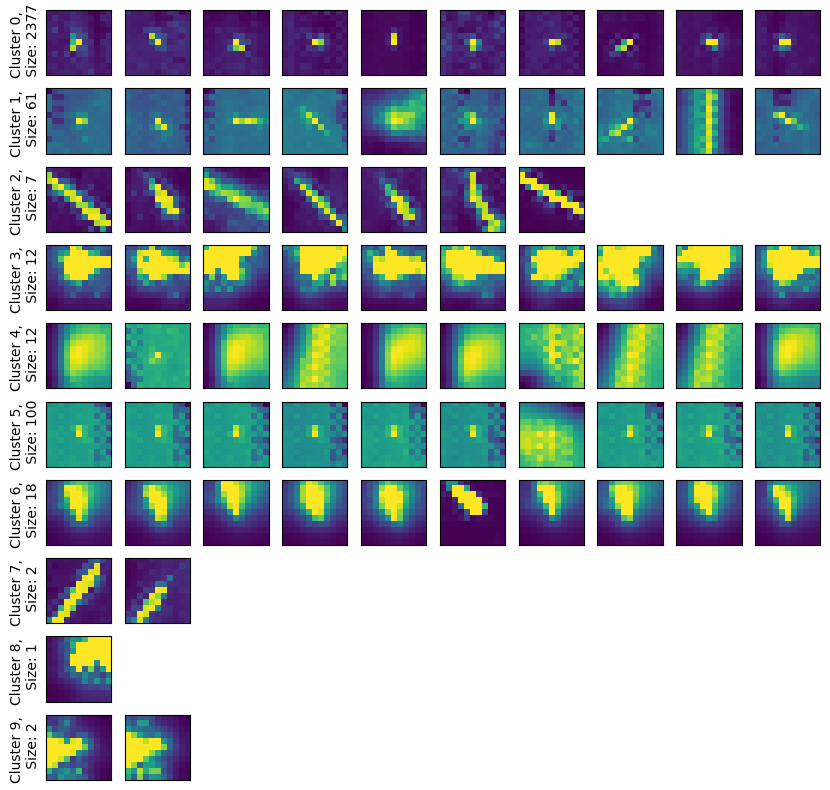

In [12]:
# Extract images. (small)
images = objects["img_norm"].to_list()
images_flattened = np.array([img.flatten() for img in images])

# Parameters.
LINKAGE = "complete"
N_CLUSTERS = 10

# Run model.
model = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage=LINKAGE)
labels = model.fit_predict(images_flattened)

agglomerative_clustering_sample(images, labels, 10)


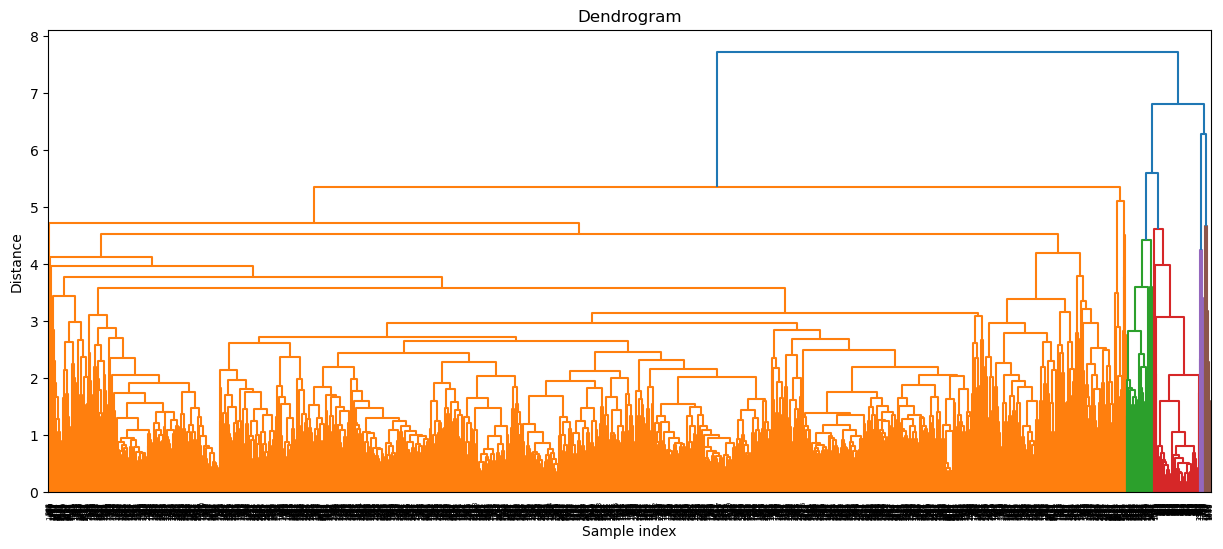

In [148]:
linkage_matrix(images_flattened, LINKAGE)

**Medium size region**

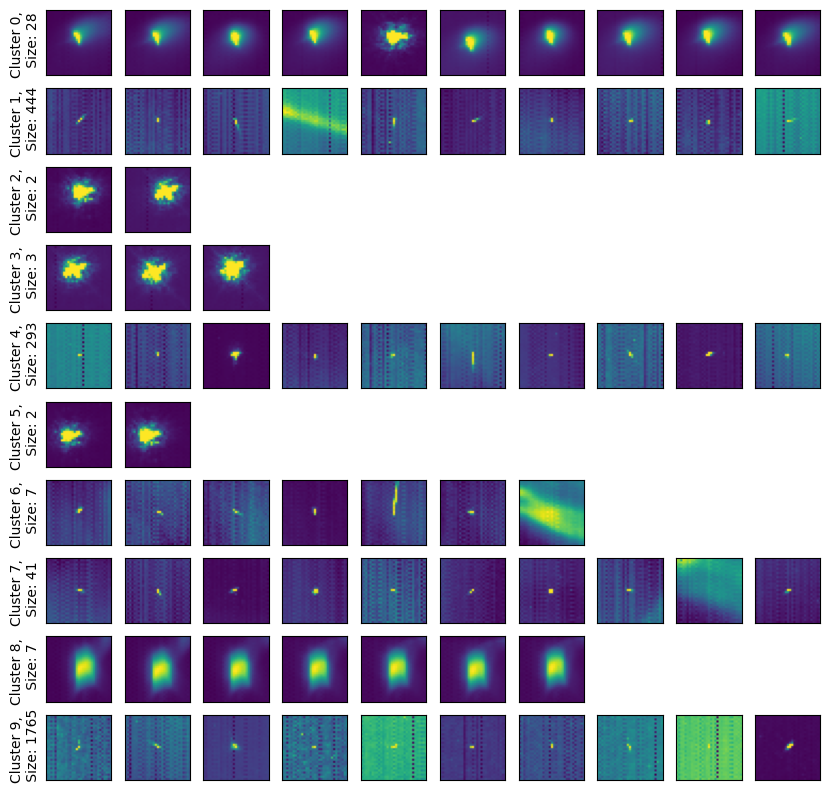

In [149]:
# Extract images. (medium)
cut = 15
images = objects["REGION"].apply(lambda x: x[cut:-cut, cut:-cut]).to_list()
images_flattened = np.array([img.flatten() for img in images])

# Parameters.
LINKAGE = "complete"
N_CLUSTERS = 10

# Run model.
model = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage=LINKAGE)
labels = model.fit_predict(images_flattened)

agglomerative_clustering_sample(images, labels, 10)

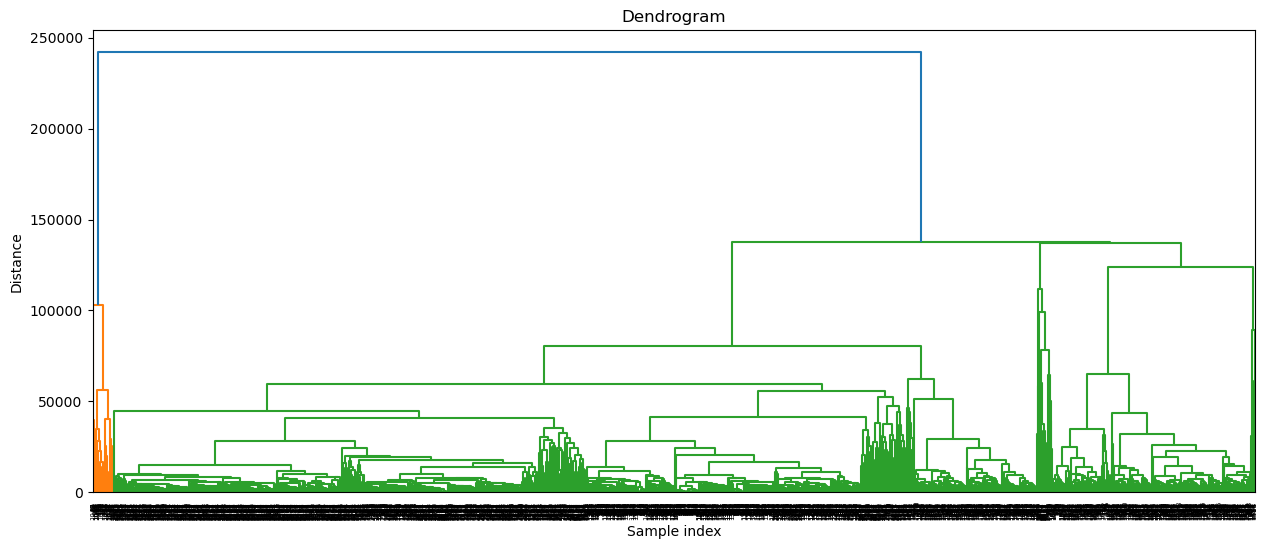

In [150]:
linkage_matrix(images_flattened, LINKAGE)

## 2. Classify PSfs.

### 2.1 Extract images with bigger size

In [190]:
size = 20
# Crop images.
objects["image_test_1"] = objects["REGION"].apply(lambda img: img[size:-size, size:-size] )
# Normalize images.
objects["image_test_1"] = objects["image_test_1"].apply(lambda img: oc.normalize_psf(img))
# Patch images.
objects["image_test_1"] = objects["image_test_1"].apply(lambda img: oc.removing_patches(img))
# Normalize images.
objects["image_test_1"] = objects["image_test_1"].apply(lambda img: oc.normalize_psf(img))

### 2.2 Remove big PSFs (saturated)

In [191]:
# Extract images.
images = objects["image_test_1"].to_list()
images_flattened = np.array([img.flatten() for img in images])

**Agglomerative clustering**

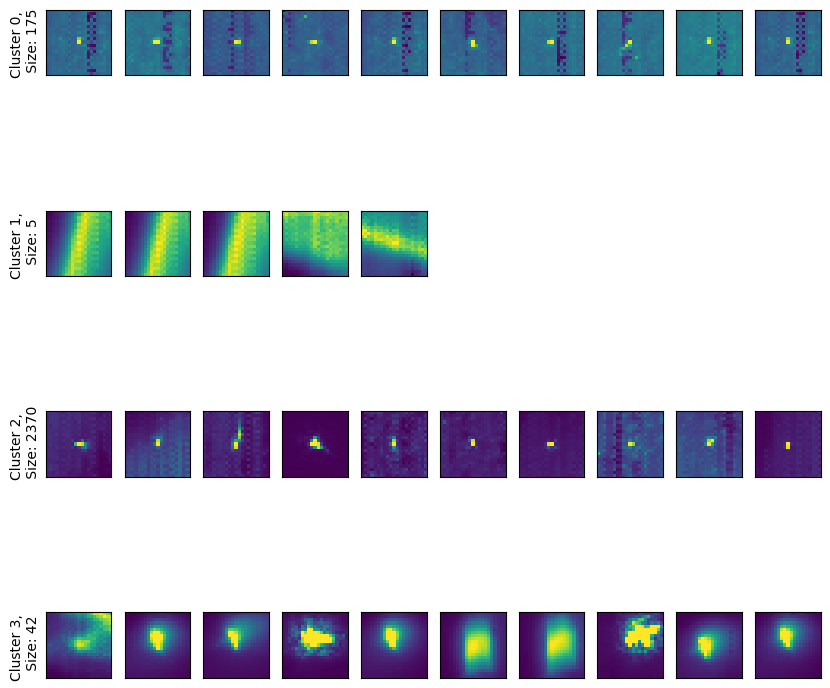

In [203]:
# Parameters.
LINKAGE = "complete"
N_CLUSTERS = 4

# Run model.
model = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage=LINKAGE)
labels = model.fit_predict(images_flattened)

agglomerative_clustering_sample(images, labels, 10)


In [204]:
objects["agl_cls_3cl_15cr"] = labels

**Agglomerative clustering with an subset**

In [205]:
new_objects = objects[objects["agl_cls_3cl_15cr"] == 2]
print(f"Datasize: {len(new_objects)}")

Datasize: 2370


In [207]:
# Extract images.
images_n = new_objects["image_test_1"].to_list()
images_flattened_n = np.array([img.flatten() for img in images_n])
print(f"Shape: {images_flattened_n.shape}")

Shape: (2370, 441)


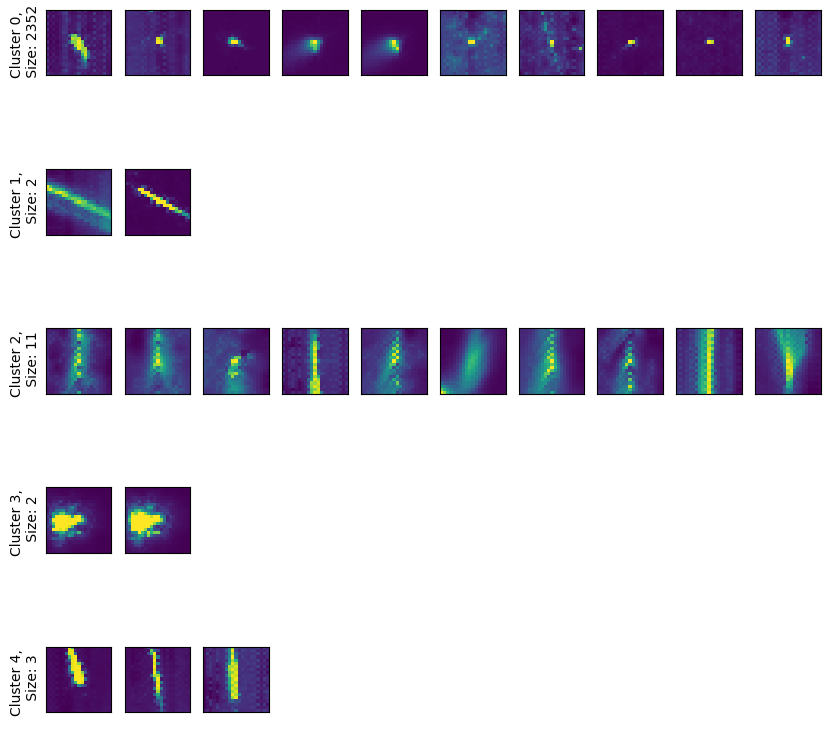

In [212]:
# Parameters.
LINKAGE = "complete"
N_CLUSTERS = 5

# Run model.
model = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage=LINKAGE)
labels = model.fit_predict(images_flattened_n)

agglomerative_clustering_sample(images_n, labels, 10)

In [213]:
new_objects["agl2_cls_4cl_15cr"] = labels

/tmp/ipykernel_9234/1679422312.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_objects["agl2_cls_4cl_15cr"] = labels


**Agglomerative clustering with other subset**

In [222]:
new_objects_2 = new_objects[new_objects["agl2_cls_4cl_15cr"] == 0]
print(f"Datasize: {len(new_objects_2)}")

# Extract images.
images_n2 = new_objects_2["image_test_1"].to_list()
images_flattened_n2 = np.array([img[5:-5, 5:-5].flatten() for img in images_n2])
print(f"Shape: {images_flattened_n2.shape}")


Datasize: 2352
Shape: (2352, 121)


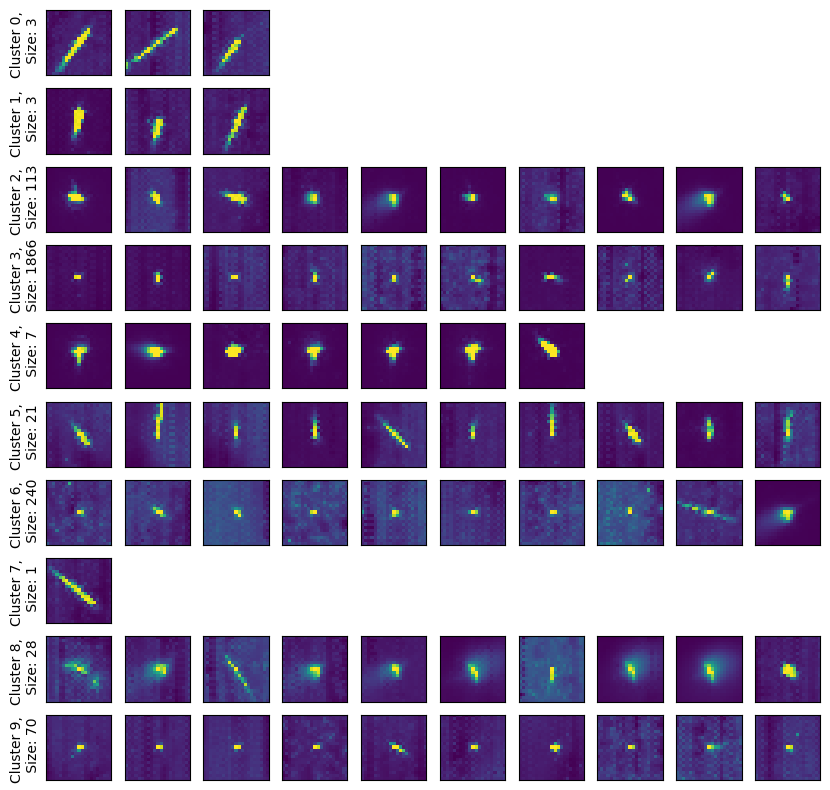

In [233]:
# Parameters.
LINKAGE = "complete"
N_CLUSTERS = 10

# Run model.
model = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage=LINKAGE)
labels = model.fit_predict(images_flattened_n2)

agglomerative_clustering_sample(images_n2, labels, 10)

# 3. Clustering with statistical features. 

**Extract features**

In [6]:

def extract_features(img):
    # Flattened stats
    flat = img.ravel()
    features = {
        "img": img,
        "max": np.max(flat),
        "min": np.min(flat),
        "mean": np.mean(flat),
        "std": np.std(flat),
        "sum": np.sum(flat),
        "skewness": stats.skew(flat),
        "kurtosis": stats.kurtosis(flat),
        "percentile_99": np.percentile(flat, 99)
    }

    # Morphological features
    try:
        binary = img > threshold_otsu(img)
    except:
        binary = img > np.percentile(img, 99)
        
    labeled = label(binary)
    props = regionprops(labeled, intensity_image=img)
    
    if props:
        r = props[0]
        features.update({
            "area": r.area,
            "eccentricity": r.eccentricity,
            "major_axis": r.major_axis_length,
            "minor_axis": r.minor_axis_length,
            "centroid_y": r.centroid[0],
            "centroid_x": r.centroid[1],
        })
    else:
        # Default values if no object detected
        features.update({
            "area": 0,
            "eccentricity": 0,
            "major_axis": 0,
            "minor_axis": 0,
            "centroid_y": 0,
            "centroid_x": 0,
        })

    return features


def visualizer_by_ley(dataframe, key, condition, value, n):
    """
    Plot n*2 samples of dataframe given a key, condition and value.

    Parameters:
        dataframe(dataframe): dataframe with images.
        key(str): column name.
        condition(str): operator for comparison.
        value (float): value for using in comparison.
        n (int): number of row and columns.

    """

    # Define operand dictionary.

    ops = {
    '==': operator.eq,
    '!=': operator.ne,
    '>': operator.gt,
    '<': operator.lt,
    '>=': operator.ge,
    '<=': operator.le,
    }

    # Take samples from dataframe based on conditions.  
    samples = dataframe[ops[condition](dataframe[key], value)]

    if len(samples) == 0:
        return "No samples found!"

    print(f"Number of samples: {len(samples)}")

    if len(samples)>= n**2:
        samples = samples.sample(n**2)


    # Start plotting.
    fig, axis = plt.subplots(n, n, figsize = (n,n))
    axis = axis.flatten()
    for i in range(n*n):
        if i < (len(samples)):
            img = samples.iloc[i]["img"]
            axis[i].set_xticks([]), axis[i].set_yticks([])
            axis[i].imshow(img)
        else:
            axis[i].axis("off")

**Test**

**Size 11**

In [7]:
size = 25
# Crop images.
objects["image_test_1"] = objects["REGION"].apply(lambda img: img[size:-size, size:-size] )
# Normalize images.
objects["image_test_1"] = objects["image_test_1"].apply(lambda img: oc.normalize_psf(img))
# Patch images.
objects["image_test_1"] = objects["image_test_1"].apply(lambda img: oc.removing_patches(img))
# Normalize images.
objects["image_test_1"] = objects["image_test_1"].apply(lambda img: oc.normalize_psf(img))
# Patch images.
objects["image_test_1"] = objects["image_test_1"].apply(lambda img: oc.removing_patches(img))
# Normalize images.
objects["image_test_1"] = objects["image_test_1"].apply(lambda img: oc.normalize_psf(img))

**Size 31**

In [8]:
size = 15
# Crop images.
objects["image_test_2"] = objects["REGION"].apply(lambda img: img[size:-size, size:-size] )
# Normalize images.
objects["image_test_2"] = objects["image_test_2"].apply(lambda img: oc.normalize_psf(img))
# Patch images.
objects["image_test_2"] = objects["image_test_2"].apply(lambda img: oc.removing_patches(img))
# Normalize images.
objects["image_test_2"] = objects["image_test_2"].apply(lambda img: oc.normalize_psf(img))

In [9]:
# Extract images.
images = objects["image_test_1"].to_list()
images_flattened = np.array([img.flatten() for img in images])

# Extract features.

features= [extract_features(img) for img in images]
features = pd.DataFrame(features)

**Visualize examples**

Number of samples: 170


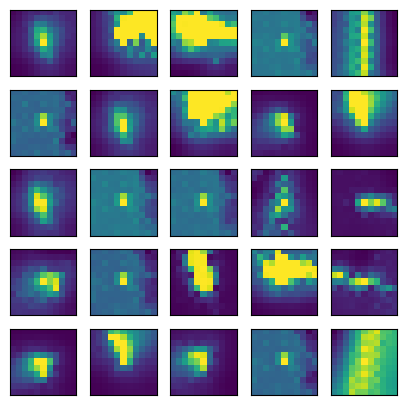

In [10]:
visualizer_by_ley(features, "area", ">", 15, 5)

**Agglomerative clustering 1**

In [11]:
features_list = features.drop(["img"], axis = 1)
features_list = [features_list.iloc[i].to_list() for i in range(len(features_list))]

images = features["img"].to_list()
images_2 = objects["image_test_2"].to_list()

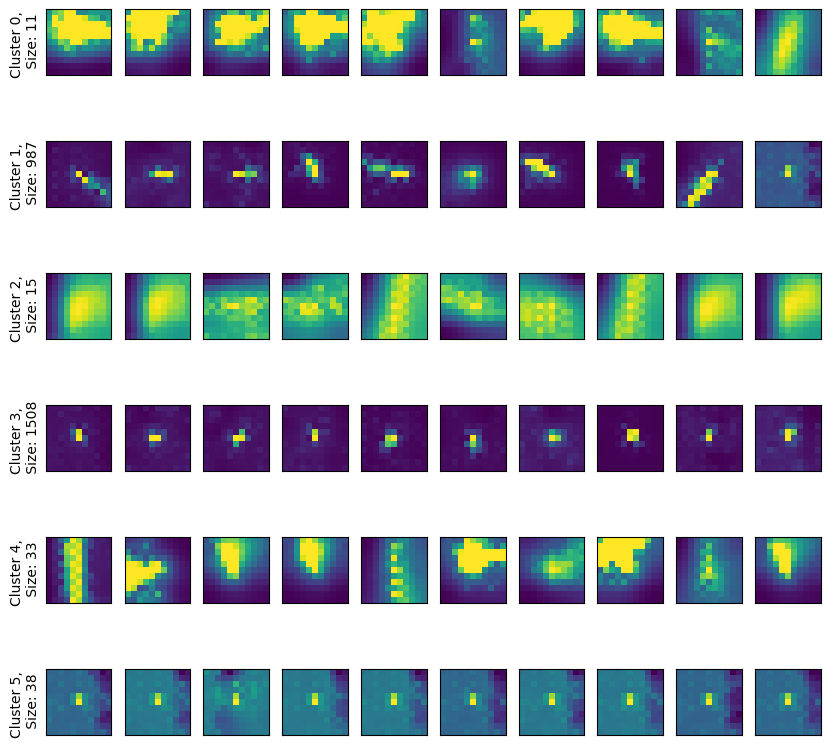

In [12]:
# Parameters.
LINKAGE = "complete"
N_CLUSTERS = 6

# Run model.
model = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage=LINKAGE)
labels = model.fit_predict(features_list)

agglomerative_clustering_sample(images, labels, 10)
features["labels_test_1"] = labels


**Display samples**

Number of samples: 11


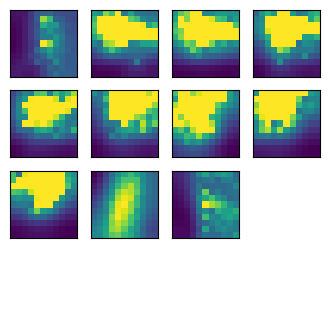

In [13]:
visualizer_by_ley(features, "labels_test_1", "==", 0, 4)

Number of samples: 15


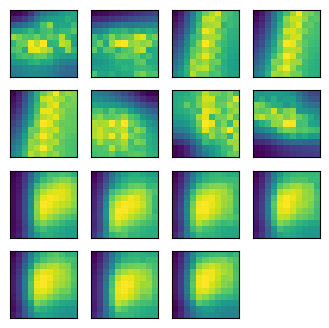

In [14]:
visualizer_by_ley(features, "labels_test_1", "==", 2, 4)

Number of samples: 33


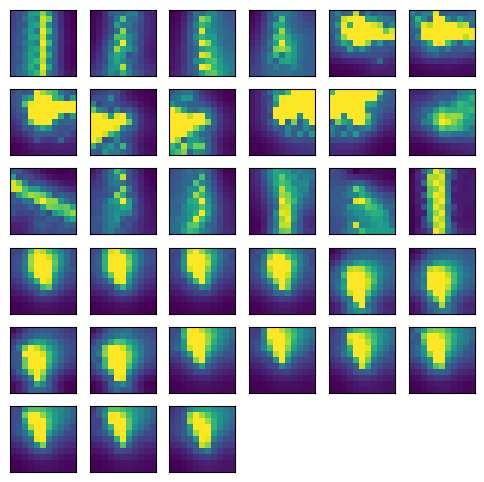

In [15]:
visualizer_by_ley(features, "labels_test_1", "==", 4, 6)

Number of samples: 38


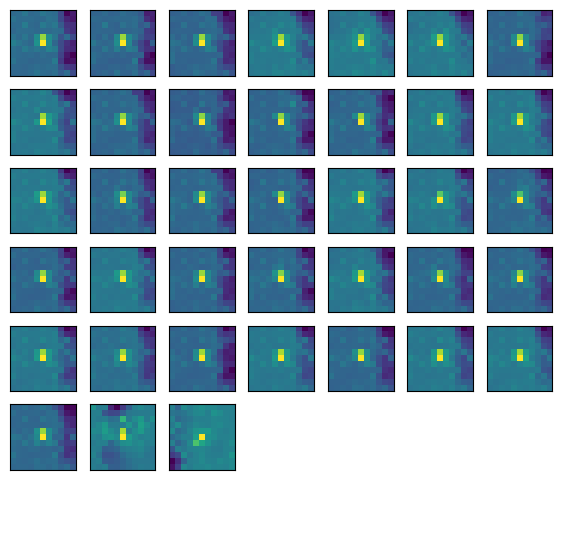

In [16]:
visualizer_by_ley(features, "labels_test_1", "==", 5, 7)

**Agglomerative clustering II**

**Based on stats**

In [17]:
new_features = features[(features["labels_test_1"] == 3) | (features["labels_test_1"] == 1)]
print(f"New size: {len(new_features)}")

New size: 2495


In [18]:
features_list2 = new_features.drop(["img","labels_test_1" ], axis = 1)
features_list2 = [features_list2.iloc[i].to_list() for i in range(len(features_list2))]

images_2 = new_features["img"].to_list()
print(f"Size of dataset: {len(features_list2)} \nImages: {len(images_2)}")

Size of dataset: 2495 
Images: 2495


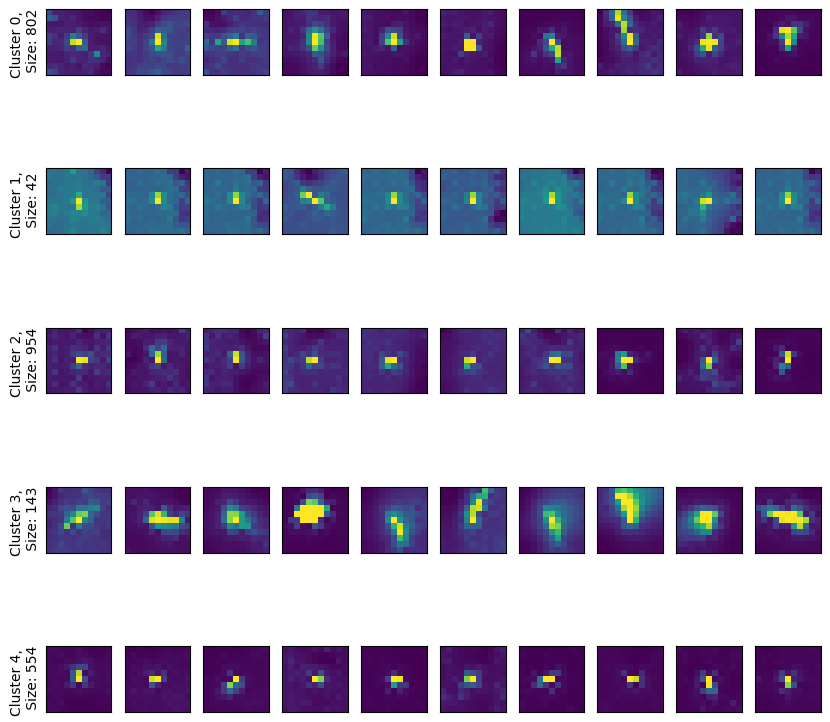

In [19]:
# Parameters.
LINKAGE = "complete"
N_CLUSTERS = 5

# Run model.
model = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage=LINKAGE)
labels = model.fit_predict(features_list2)

agglomerative_clustering_sample(images_2, labels, 10)

**Based on pixel intensities**

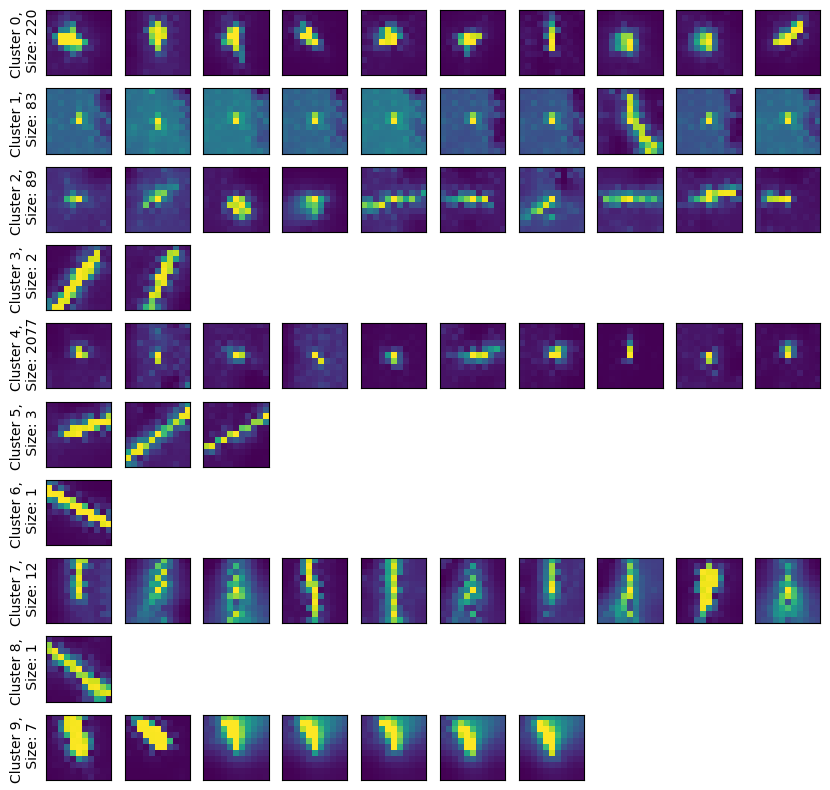

In [20]:
images_flattened = [img.flatten() for img in images_2]

# Parameters.
LINKAGE = "complete"
N_CLUSTERS = 10

# Run model.
model = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage=LINKAGE)
labels = model.fit_predict(images_flattened)

agglomerative_clustering_sample(images_2, labels, 10)


# 4. Clustering with Autoencoders.

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

## 4.1 Main functions

In [7]:
class PSFDataset(Dataset):
    """
    Dataset class that loads 2d numpy arrays and creates torch tensor for machine learning training.

    Parameters:
        images (list) : list of 2d numpy arrays with PSFs images (15x15)
    """

    def __init__(self, psf_list):
        """
        Convert each image into a torch tensor and add a channel dimension.
        """

        self.data = [torch.tensor(img, dtype=torch.float32).unsqueeze(0) for img in psf_list]

    def __len__(self):
        """
        Return total number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieve the PSF image at the specified index.
        """
        return self.data[idx]

import torch
import torch.nn as nn

class PSFAutoencoder(nn.Module):
    """
    Autoencoder architecture that reconstructs a given Point Spread Function.
    Learns the latent dimension of the samples.
    """
    def __init__(self, channel_a, psf_size, latent_dim=5):
        super(PSFAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, channel_a, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2, ceil_mode=True),
            nn.Conv2d(channel_a, channel_a * 2, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2, ceil_mode=True)
        )                             

        # 🔧 Dynamically infer the shape after encoder
        with torch.no_grad():
            dummy = torch.zeros(1, 1, psf_size, psf_size)
            enc_out = self.encoder(dummy)
            _, C, H, W = enc_out.shape
            in_features = C * H * W
            self._unflatten_shape = (C, H, W) 
            out_features = C*H*W # <-- Store this for Unflatten

        # Dense encoder
        self.encoder_dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, 24),
            nn.ReLU(),
            nn.Linear(24, latent_dim)
        )

        # Dense decoder
        self.decoder_dense = nn.Sequential(
            nn.Linear(latent_dim, 24),
            nn.ReLU(),
            nn.Linear(24, in_features),
            nn.Unflatten(1, self._unflatten_shape)  # ✅ Use stored shape
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d( channel_a*2, channel_a, kernel_size=2, stride=2),  
            nn.ReLU(),
            nn.ConvTranspose2d(channel_a, 1, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size=2),
            nn.Sigmoid()  # Optional: use if your PSFs are scaled between 0–1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.encoder_dense(x)
        x = self.decoder_dense(x)
        x = self.decoder(x)
        return x
    
    def get_latent(self, x):
        x = self.encoder(x)
        x = self.encoder_dense(x)
        return x



    def forward(self, x):
        """
        Forward pass of the autoencoder.

        Parameters:
            x (torch tensor): input tensor.
        Output:
            x (torch tensor): reconstructed tensor.ù
        """
        x = self.encoder(x)
        x = self.encoder_dense(x)
        x = self.decoder_dense(x)
        x = self.decoder(x)
        return x
    
    def get_latent(self, x):
        """
        Forward pass of the autoencoder and save the latent representation.
        """
        x = self.encoder(x)
        x = self.encoder_dense(x)
        return x


def train_autoencoder(psf_size, psf_images, epochs=20, batch_size=16, lr=1e-3,
                     n_channels = 11, latent_dim = 5,  verbose = False):
    """
    Training funtion of the autoencoder architecture. Takes a normalized PSF image and 
    extract the latent dimension. Then, reconstruct the image and compute accuracy and loss.
    
    Parameters:
        psf_images (dataloader): list with images.
        epochs (int): number of epochs for training.
        batch_size (int): size of the batch.
        lr (float): learning rate for optimizer.
        n_channels (int): number of channels to be created in the convolutional layers.
        latent_dim (int): number of neurons for the latent dimension.
        verbose (bool): show training loss.
    Output:
        model (torch model): trained model.

    """
    # Use GPU.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load dataset.
    dataset = PSFDataset(psf_images)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Run model
    model = PSFAutoencoder(channel_a=n_channels, latent_dim= latent_dim, psf_size=psf_size).to(device)
    # Define optimizer.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Measure pixel wise mean squared error between input and output.
    criterion = nn.MSELoss()
    loss_values = []
    # Iterate for epochs.
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        # Iterate for batches.
        for batch in dataloader:
            # Send batch to GPU.
            batch = batch.to(device)
            # Forward pass.
            output = model(batch)
            # Compare original image with reconstructed sample.
            loss = criterion(output, batch)
            # Reset gradients.
            optimizer.zero_grad()
            # Backpropagation.
            loss.backward()
            # Update weights.
            optimizer.step()

            total_loss += loss.item()
            
        if verbose:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(dataloader):.6f}")
        loss_values.append(total_loss/len(dataloader))
    
    print(f"Training finished.")
    
    return model, loss_values


In [8]:
def display_samples_ae(model, images, n_samples):
    """
    Display original samples vs reconstructed samples retrieved from an autoencoder.

    Parameters:
        model (torch model): trained autoencoder model.
        images (torch dataset): torch images.
        n_samples (int): number of samples to show.
    """

    # Create plot.
    fig, axis = plt.subplots(2, n_samples, figsize = (15, 3))
    # Take random indexes.
    indexes = np.random.randint(0, len(images), n_samples)

    for i in range(n_samples):
        # Take image from sample.
        sample = images[i].unsqueeze(0)
        device = next(model.parameters()).device
        # Send sample to GPU.
        sample = sample.to(device)
        # Get reconstruction
        with torch.no_grad():
            # Run model.
            reconstructed = model(sample)

        # Convert back to NumPy for plotting
        original_np = sample.squeeze().cpu().numpy()
        reconstructed_np = reconstructed.squeeze().cpu().numpy()   

        axis[0,i].imshow(original_np)
        axis[1,i].imshow(reconstructed_np)
        axis[0,i].set_xticks([]), axis[0,i].set_yticks([])
        axis[1,i].set_xticks([]), axis[1,i].set_yticks([])


def extract_latents(model, psf_images, batch_size=32):
    """
    Extract latent dimension from the images using a trained model. 

    Parameters:
        model (torch model): previously trained model.
        psf_images (images): images with samples
        batch_size (int): size of the batch.

    Output:
        latents_array (array): extracted features of the images.
    """
    model = model.to("cuda")
    model.eval()

    dataset = PSFDataset(psf_images)  
    dataloader = DataLoader(dataset, batch_size=batch_size)

    all_latents = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to("cuda")
            latents = model.get_latent(batch)  
            all_latents.append(latents.cpu().numpy())

    latents_array = np.concatenate(all_latents, axis=0)
    return latents_array




## 4.2 Auto-encoder with 2 latent dimensions.

In [92]:
size = 25
# Crop images.
objects["image_test_1"] = objects["REGION"].apply(lambda img: img[size:-size, size:-size] )
# Normalize images.
objects["image_test_1"] = objects["image_test_1"].apply(lambda img: oc.normalize_psf(img))
# Patch images.-
objects["image_test_1"] = objects["image_test_1"].apply(lambda img: oc.removing_patches(img))
# Normalize images.
objects["image_test_1"] = objects["image_test_1"].apply(lambda img: oc.normalize_psf(img))
# Patch images.
objects["image_test_1"] = objects["image_test_1"].apply(lambda img: oc.removing_patches(img))
# Normalize images.
objects["image_test_1"] = objects["image_test_1"].apply(lambda img: oc.normalize_psf(img))
# Patch images.
objects["image_test_1"] = objects["image_test_1"].apply(lambda img: oc.removing_patches(img))
# Normalize images.
objects["image_test_1"] = objects["image_test_1"].apply(lambda img: oc.normalize_psf(img))

Training finished.


Text(0.5, 1.0, 'Autoencoder training.')

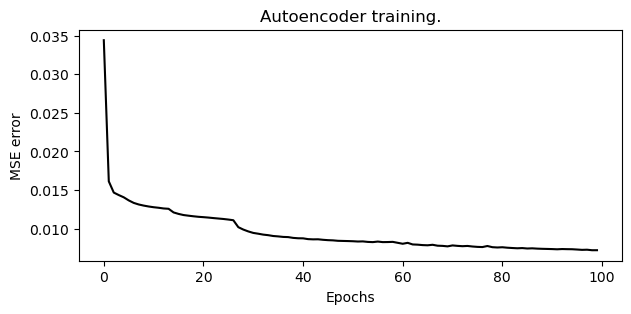

In [93]:
# Prepare model.
images = objects["image_test_1"].to_list()

# Parameters
LATENT_DIM = 2
EPOCHS = 100
N_CHANNELS = 8
PSF_SIZE = images[0].shape[0]

# Train model.
model, loss = train_autoencoder(PSF_SIZE, images, epochs=EPOCHS, n_channels= N_CHANNELS,latent_dim= LATENT_DIM, verbose= False)

# Display loss.
fig, axis = plt.subplots(1, 1, figsize = (7, 3))
axis.plot(loss, color = "black")
axis.set_xlabel("Epochs")
axis.set_ylabel("MSE error")
axis.set_title("Autoencoder training.")

**Display examples**

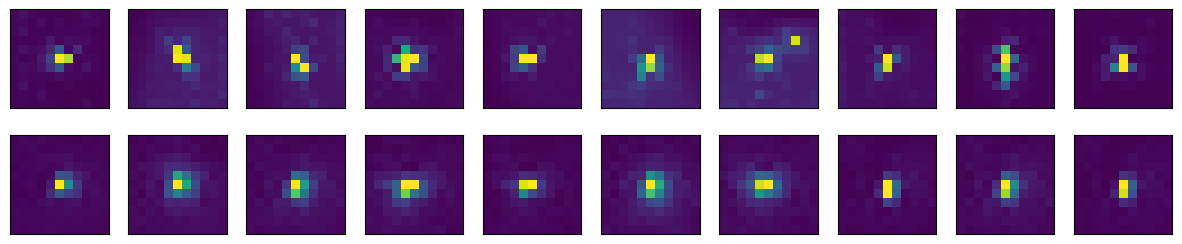

In [94]:
display_samples_ae(model, PSFDataset(images), 10)

In [95]:
# Extract latent dimension of each PSF.
features = extract_latents(model, images, 32)

**K-means**

Compactness: 2678.424859766965


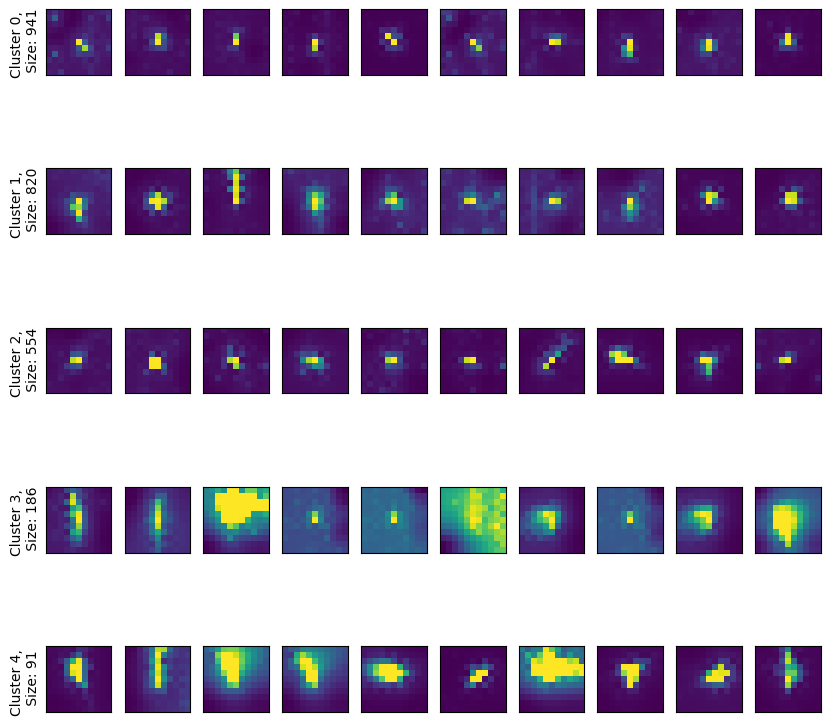

In [96]:

# K-means parameters.
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.01)
CLUSTERS = 5
ATTEMPTS = 12

# Run model.
compactness, labels, centroids = k_means_nn(features, CLUSTERS, ATTEMPTS, CRITERIA)

# Display samples.
kmeans_sample(images, labels, 10)
print(f"Compactness: {compactness}")

*2D representation*

/tmp/ipykernel_11115/2252559730.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Clusters")


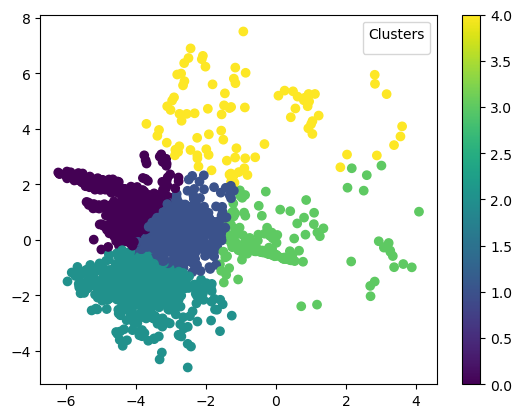

In [97]:
plt.scatter(features[:,0], features[:,1], c = labels)
plt.legend(title="Clusters")
plt.colorbar()

**Agglomerative clustering**

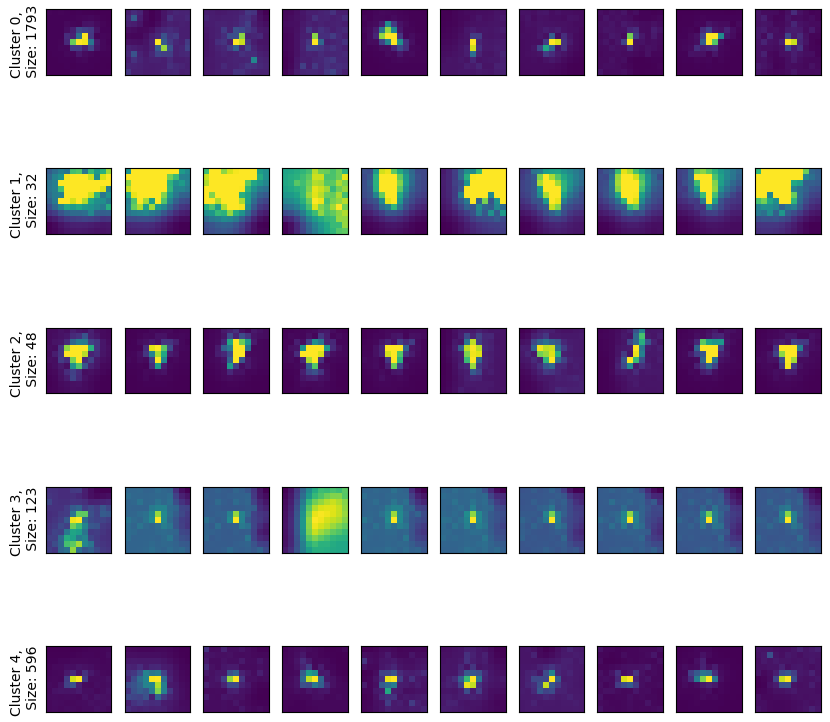

In [98]:
# Parameters.
LINKAGE = "complete"
N_CLUSTERS = 5

# Run model.
model = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage=LINKAGE)
labels = model.fit_predict(features)

agglomerative_clustering_sample(images, labels, 10)


*2D representation*

/tmp/ipykernel_11115/2252559730.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Clusters")


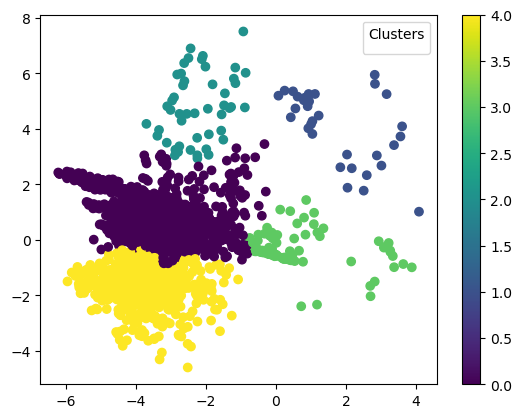

In [99]:
plt.scatter(features[:,0], features[:,1], c = labels)
plt.legend(title="Clusters")
plt.colorbar()

**DBSCAN**

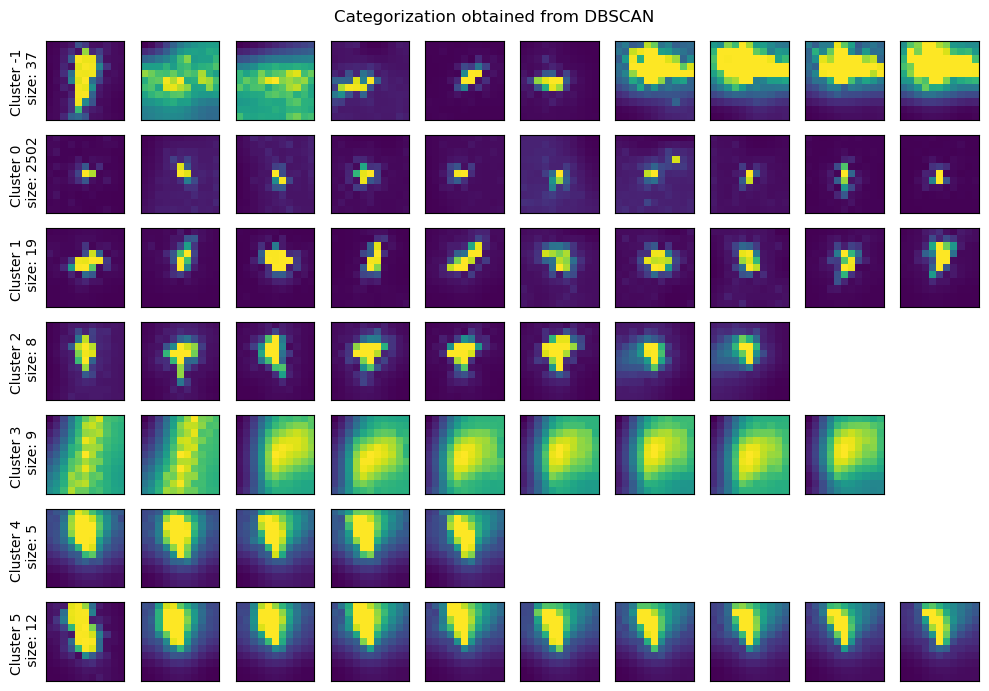

In [100]:
# Find optimal eps.
MIN_SAMPLES = 5

distances, eps = dbscan_eps_finder(features, MIN_SAMPLES )

# Run dbscan.
labels = dbscan(features, distances[eps], MIN_SAMPLES)

# Display samples.
dbscan_samples(images, labels, 10)

*2D representation*

/tmp/ipykernel_11115/2252559730.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Clusters")


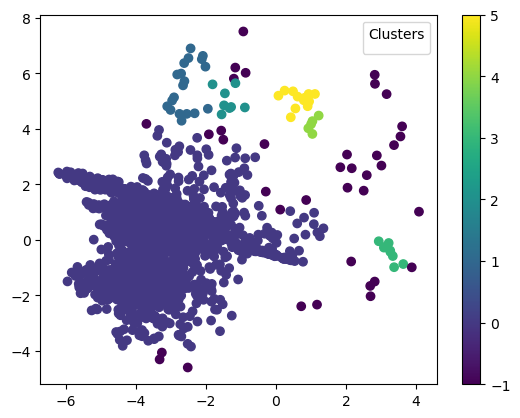

In [101]:
plt.scatter(features[:,0], features[:,1], c = labels)
plt.legend(title="Clusters")
plt.colorbar()

## 4.3 Auto-encoder with remanent subset.

In [102]:
objects["label_autoencoder_1"] = labels
new_objects = objects[objects["label_autoencoder_1"] == 0]
print(f"Size of new dataset: {len(new_objects)}")

Size of new dataset: 2502


**Train again an autoencoder**

Training finished.


Text(0.5, 1.0, 'Autoencoder training.')

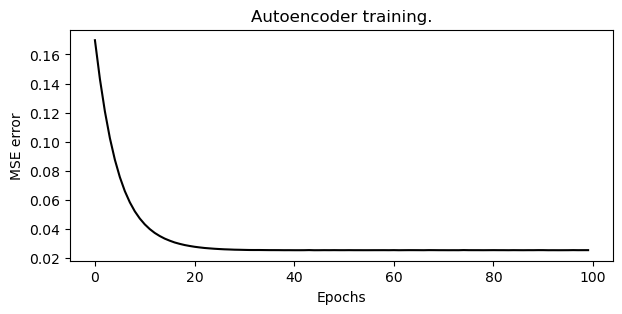

In [103]:
# Prepare data.
#new_objects["image_test_2"] = new_objects["image_test_1"].apply(lambda img: img[2:-2, 2:-2])
#images_2 = new_objects["image_test_2"].to_list()
images_2 = new_objects["image_test_1"].to_list()

# Parameters
LATENT_DIM = 2
EPOCHS = 100
N_CHANNELS = 8
PSF_SIZE = images_2[0].shape[0]

# Train model.

model_2, loss_2 = train_autoencoder(PSF_SIZE, images_2, epochs=EPOCHS, n_channels= N_CHANNELS,latent_dim= LATENT_DIM, verbose= False)

# Display loss.
fig, axis = plt.subplots(1, 1, figsize = (7, 3))
axis.plot(loss_2, color = "black")
axis.set_xlabel("Epochs")
axis.set_ylabel("MSE error")
axis.set_title("Autoencoder training.")

In [104]:
# Extract latent dimension of each PSF.
features = extract_latents(model_2, images_2, 32)

**Agglomerative clustering**

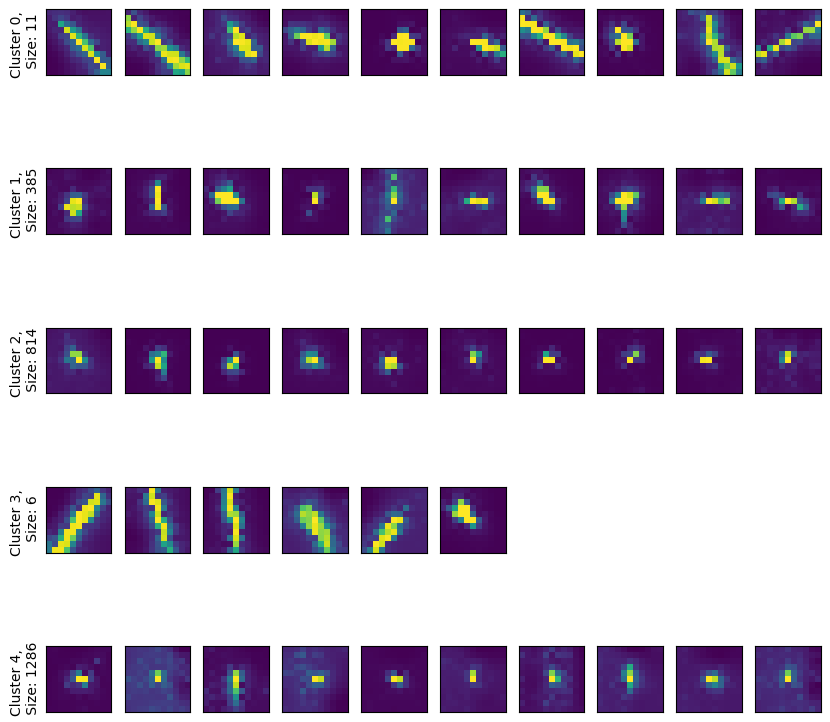

In [105]:
# Parameters.
LINKAGE = "complete"
N_CLUSTERS = 5

# Run model.
model = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage=LINKAGE)
labels = model.fit_predict(features)

agglomerative_clustering_sample(images_2, labels, 10)


/tmp/ipykernel_11115/2252559730.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Clusters")


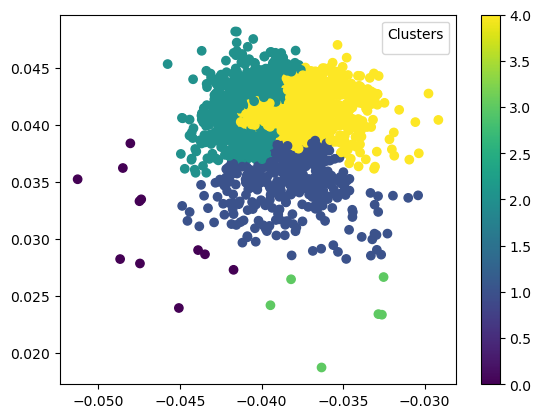

In [106]:
plt.scatter(features[:,0], features[:,1], c = labels)
plt.legend(title="Clusters")
plt.colorbar()

**DBSCAN**

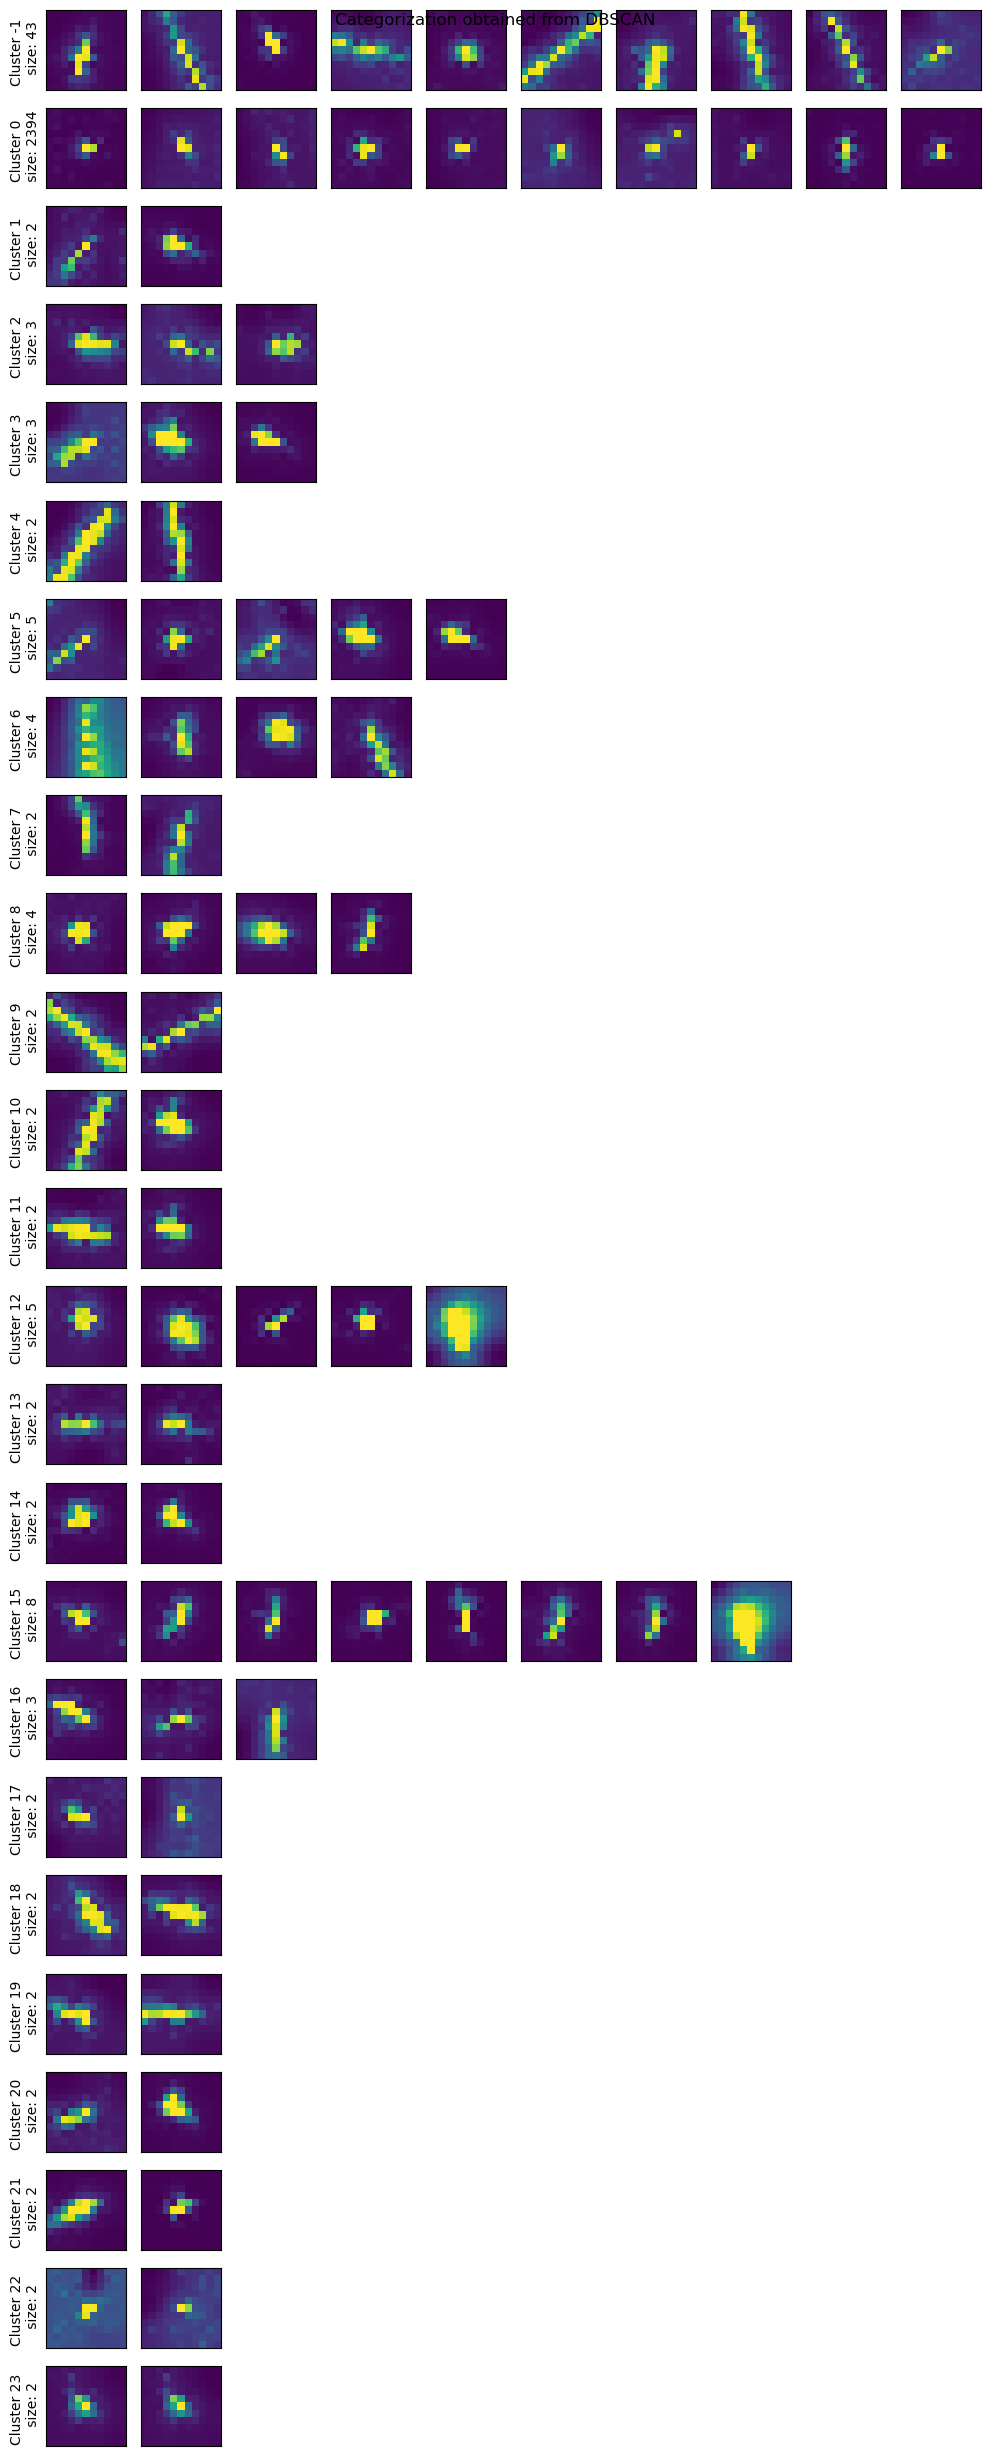

In [107]:
# Find optimal eps.
MIN_SAMPLES = 2
distances, eps = dbscan_eps_finder(features, MIN_SAMPLES )

# Run dbscan.
labels_2 = dbscan(features, distances[eps], MIN_SAMPLES)

# Display samples.
dbscan_samples(images_2, labels_2, 10)

/tmp/ipykernel_11115/3647971183.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Clusters")


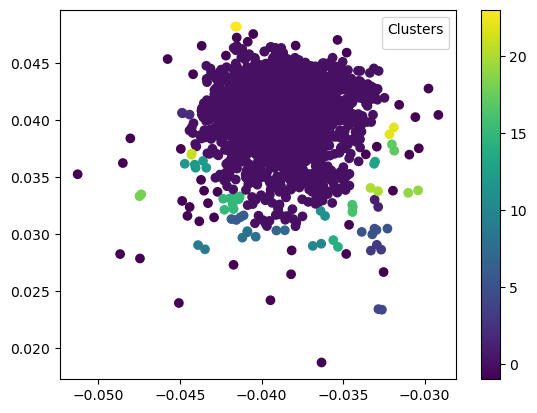

In [108]:
plt.scatter(features[:,0], features[:,1], c = labels_2)
plt.legend(title="Clusters")
plt.colorbar()

## 4.4 Autoencoder again

In [109]:
new_objects["label_autoencoder_2"] = labels_2
new_objects2 = new_objects[new_objects["label_autoencoder_2"] == 0]
print(f"Size of new dataset: {len(new_objects2)}")

Size of new dataset: 2394


/tmp/ipykernel_11115/3189853383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_objects["label_autoencoder_2"] = labels_2


Training finished.


Text(0.5, 1.0, 'Autoencoder training.')

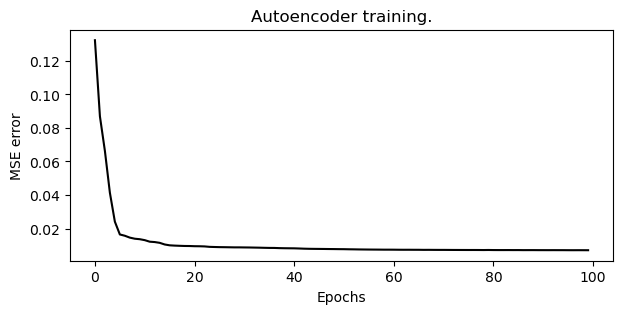

In [110]:
# Prepare data.
#new_objects2["image_test_2"] = new_objects2["image_test_1"].apply(lambda x: x[3:-3, 3:-3])
images_3 = new_objects2["image_test_1"].to_list()

# Parameters
LATENT_DIM = 2
EPOCHS = 100
N_CHANNELS = 11
PSF_SIZE = images_3[0].shape[0]
# Train model.
model_3, loss_3 = train_autoencoder(psf_size=PSF_SIZE, psf_images = images_3, epochs=EPOCHS, n_channels= N_CHANNELS,latent_dim= LATENT_DIM, verbose= False)

# Display loss.
fig, axis = plt.subplots(1, 1, figsize = (7, 3))
axis.plot(loss_3, color = "black")
axis.set_xlabel("Epochs")
axis.set_ylabel("MSE error")
axis.set_title("Autoencoder training.")

In [111]:
# Extract latent dimension of each PSF.
features_3 = extract_latents(model_3, images_3, 32)
len(images_3)

2394

**Agglomerative clustering**

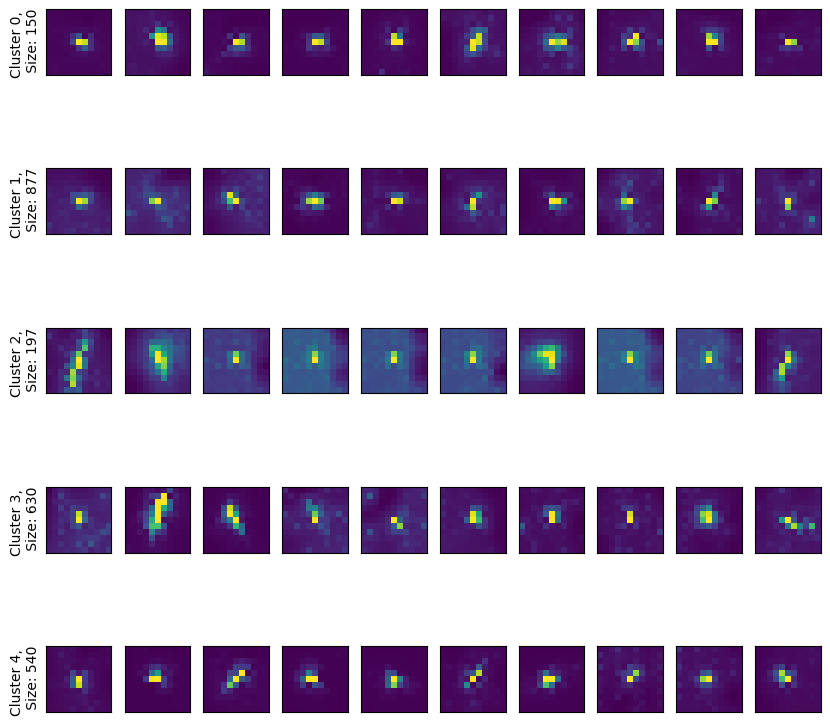

In [112]:
# Parameters.
LINKAGE = "complete"
N_CLUSTERS = 5

# Run model.
model = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage=LINKAGE)
labels = model.fit_predict(features_3)

agglomerative_clustering_sample(images_3, labels, 10)


/tmp/ipykernel_11115/3613732150.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Clusters")


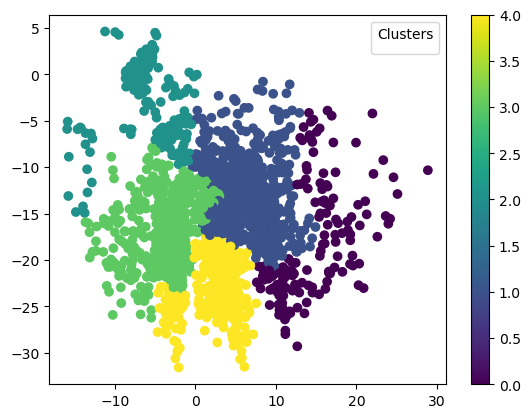

In [113]:
plt.scatter(features_3[:,0], features_3[:,1], c = labels)
plt.legend(title="Clusters")
plt.colorbar()

**DBSCAN**

2394


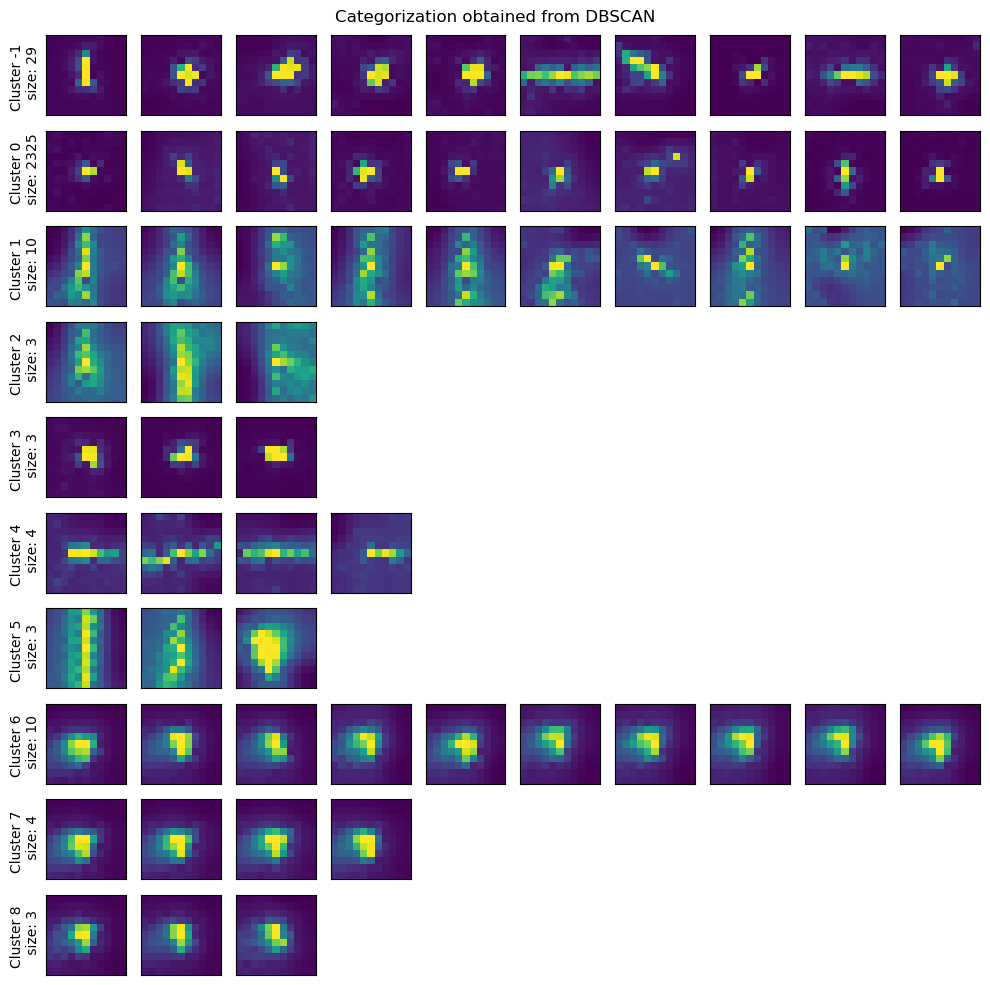

In [114]:
# Find optimal eps.
MIN_SAMPLES = 3
distances, eps = dbscan_eps_finder(features_3, MIN_SAMPLES )

# Run dbscan.
labels_3 = dbscan(features_3, distances[eps], MIN_SAMPLES)

# Display samples.
dbscan_samples(images_3, labels_3, 10)

print(len(labels_3))

/tmp/ipykernel_11115/1860944679.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Clusters")


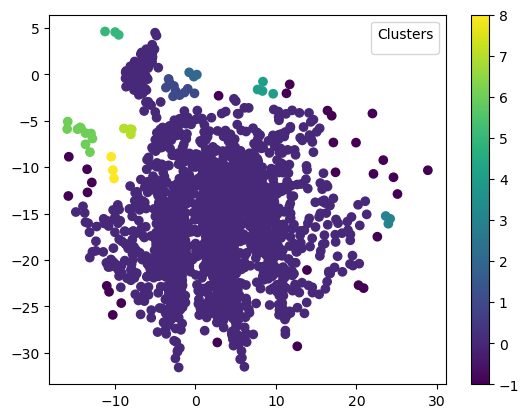

In [115]:
plt.scatter(features_3[:,0], features_3[:,1], c = labels_3)
plt.legend(title="Clusters")
plt.colorbar()

In [116]:
new_objects2["label_autoencoder_3"] = labels_3
new_objects_3 = new_objects2[new_objects2["label_autoencoder_3"] == 0]

images_3a = new_objects_3["image_test_1"].to_list()
images_3a_flattened = [img.flatten() for img in images_3a]


/tmp/ipykernel_11115/3870472118.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_objects2["label_autoencoder_3"] = labels_3


In [117]:
# Apply PCA with 95% of information retaining.
pca = PCA(n_components= 2)
pca_images = pca.fit_transform(images_3a_flattened)

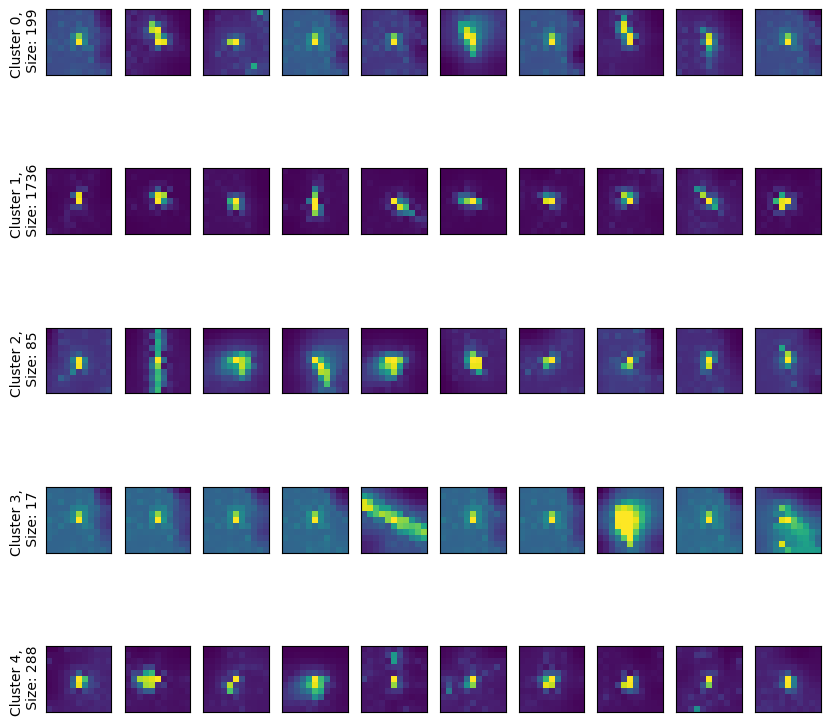

In [118]:
# Parameters.
LINKAGE = "complete"
N_CLUSTERS = 5

# Run model.
model = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage=LINKAGE)
labels = model.fit_predict(pca_images)

agglomerative_clustering_sample(images_3a, labels, 10)


/tmp/ipykernel_11115/2050986275.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Clusters")


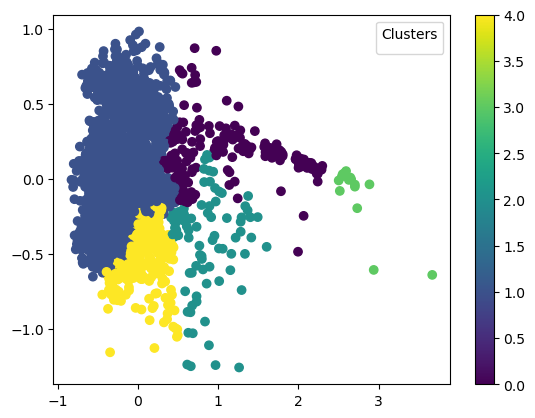

In [119]:
plt.scatter(pca_images[:,0], pca_images[:,1], c = labels)
plt.legend(title="Clusters")
plt.colorbar()

2325


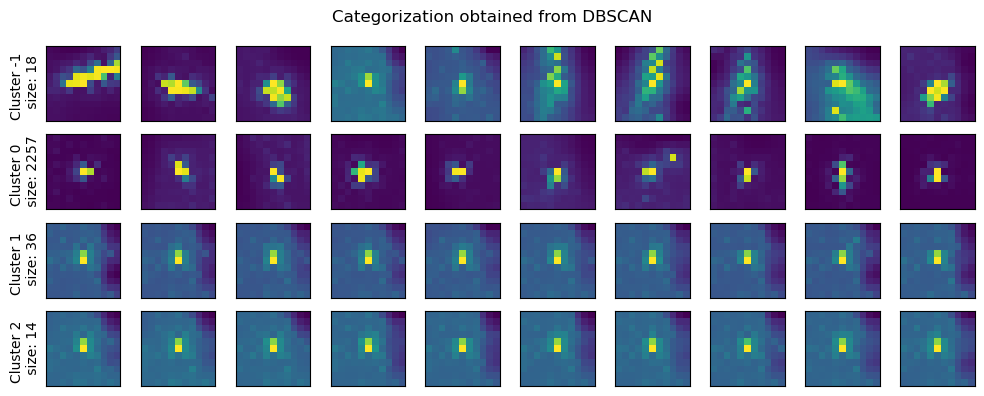

In [120]:
# Find optimal eps.
MIN_SAMPLES = 3
distances, eps = dbscan_eps_finder(pca_images, MIN_SAMPLES )

# Run dbscan.
labels_3 = dbscan(pca_images, distances[eps], MIN_SAMPLES)

# Display samples.
dbscan_samples(images_3a, labels_3, 10)

print(len(labels_3))

/tmp/ipykernel_11115/716175501.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Clusters")


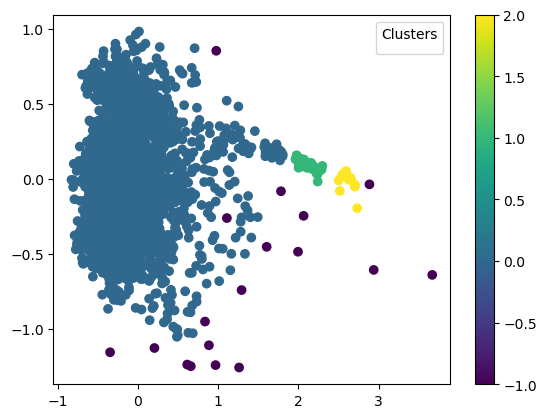

In [121]:
plt.scatter(pca_images[:,0], pca_images[:,1], c = labels_3)
plt.legend(title="Clusters")
plt.colorbar()

new

**DBSCAN**

In [122]:
from sklearn.decomposition import PCA

# Check number of components for the previously flatten and scaled PSFs.
pca = PCA(n_components= len(scaled_images[0]))
# Apply dimensionality reduction.
psfs_pca = pca.fit_transform(scaled_images)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# Take number of component that preserves 95% of information.
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1


# Display Cummulative Explained variance.
fig, axis = plt.subplots(1, 1, figsize = (6, 6))
axis.plot(np.cumsum(pca.explained_variance_ratio_), color ="black")
axis.grid()
axis.set_xlabel("Number of components")
axis.set_ylabel("Cummulative Explained Variance")
axis.set_title("Explained variance ratio")
axis.axvline(n_components_95, color ="red", label = f"95: {n_components_95}")
axis.axvline(n_components_90, color ="blue", label = f"90: {n_components_90}")
axis.axvline(n_components_80, color ="green", label = f"80: {n_components_80}")
axis.legend()

NameError: name 'scaled_images' is not defined

In [ ]:
def kmeans_sample(images, labels, n_samples, original_shape = 11):  
    """
    Display samples for each obtained cluster from K-means algorithm.

    Parameters:
        images (list): flatten input images.
        labels (array): array with obtained cluster labels.
        n_samples (int): number of samples to plot from each cluster.    
        original_shape (int): original height of the input image.
    """
    # Extract clusters.
    unique, counts = np.unique(labels, return_counts=True)

    # Merge images with respective labels.
    pairs = list(zip(images, labels))

    # Create plot.
    fig, axis = plt.subplots(len(unique), n_samples, figsize = (10, 10))

    for i in range(len(unique)):
        samples = [img.reshape(original_shape,original_shape) for img, lbl in pairs if lbl == i]
        samples_r = random.sample(samples, n_samples)
        axis[i,0].set_ylabel(f"Cluster {i}, \n Size: {len(samples)}")
        for j in range(n_samples):
            axis[i, j].imshow(samples_r[j])
            axis[i, j].set_xticks([])
            axis[i, j].set_yticks([])

Compactness: 85047.66691350937


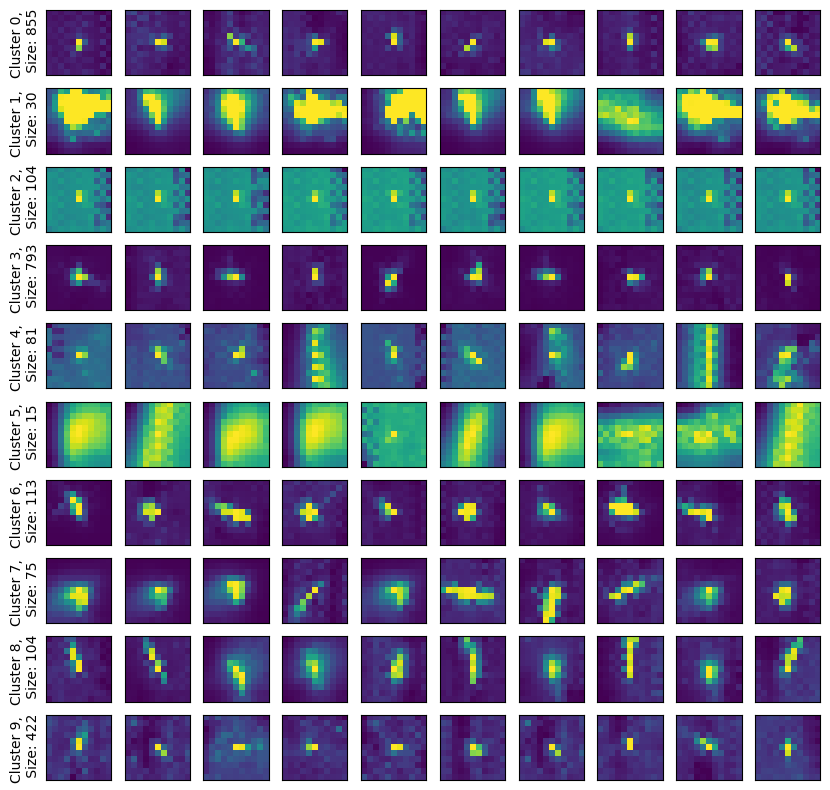

In [23]:
# Apply PCA with 95% of information retaining.
pca = PCA(n_components= n_components_95)
pca_images = pca.fit_transform(scaled_images)

# K-means parameters.
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.01)
CLUSTERS = 10
ATTEMPTS = 12

# Run model.
compactness_1pca, labels_1pca, centroids_1pca = k_means_nn(pca_images, CLUSTERS, ATTEMPTS, CRITERIA)

# Display samples.
kmeans_sample(images, labels_1pca, 10)
print(f"Compactness: {compactness_1pca}")

No enough samples for cluster: 2
No enough samples for cluster: 2
No enough samples for cluster: 2
No enough samples for cluster: 2
No enough samples for cluster: 2
No enough samples for cluster: 3
No enough samples for cluster: 3
No enough samples for cluster: 3


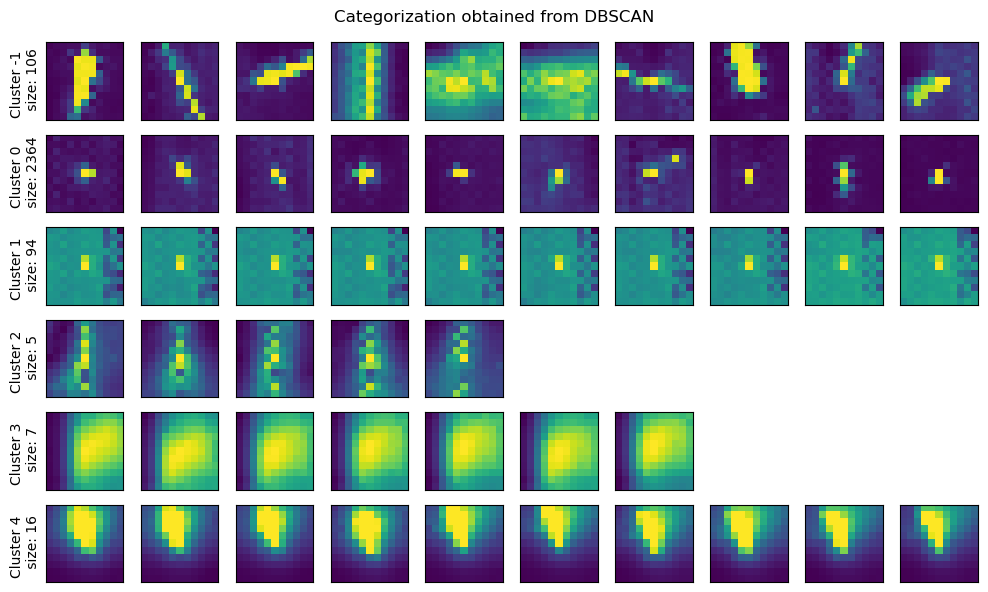

In [26]:
# Apply PCA with 95% of information retaining.
pca = PCA(n_components= n_components_95)
pca_images = pca.fit_transform(scaled_images)

# Find optimal eps.
MIN_SAMPLES = 5
distances, eps = dbscan_eps_finder(pca_images, MIN_SAMPLES )

# Run dbscan.
labels_95 = dbscan(scaled_images, distances[eps], MIN_SAMPLES)

# Display samples.
dbscan_samples(images, labels_95, 10, 11)
